In [275]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


os.getcwd()
ames_dimreduced = pd.read_csv(r"C:\Users\willf\OneDrive\Documents\NYDSA\Machine Learning Project\AMES_GIT\ames_dimreduced.csv", keep_default_na=False)

In [276]:
# Drop target var and unnecessary columns
ames_dimreduced = ames_dimreduced.drop(columns=['Unnamed: 0', 'PID', 'LogSalePrice'])
ames_dimreduced['OverallQual']


0       6
1       5
2       5
3       4
4       8
       ..
2551    6
2552    3
2553    5
2554    7
2555    8
Name: OverallQual, Length: 2556, dtype: int64

In [277]:
# Run XGboost with target encoding and pipeline creation

import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce


# Define dataset
X = ames_dimreduced.drop('SalePrice', axis=1)
y = ames_dimreduced['SalePrice']

# Create target encoder 
target_encoder = ce.TargetEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])

# Create transformer for target encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_encoder, ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])
    ], remainder='passthrough'
)

# Create a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', xgb_preprocessor),
                           ('regressor', xgb.XGBRFRegressor(objective='reg:squarederror', random_state=42))])

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Fit the pipeline
xgb_pipeline.fit(X_train, y_train)

# Evaluate
xgb_predictions = xgb_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

# Perform CV
scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", scores)


RMSE: 25453.55790472651
R-squared: 0.8943799170859765
Cross-validated R-squared scores: [0.86917508 0.88237441 0.90327528 0.88776952 0.88555892]


In [278]:
len(X_train.columns)

44

In [279]:
# Tune xgboost hyperparams

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Create XGboost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparams grid
param_dist = {
    'regressor__n_estimators': randint(100,1000),
    'regressor__learning_rate': uniform(0.01, 0.6),
    'regressor__max_depth': randint(3, 10),
    'regressor__min_child_weight': randint(1, 6),
    'regressor__gamma': uniform(0, 0.5),
    'regressor__subsample': uniform(0.5, 0.5),
    'regressor__colsample_bytree': uniform(0.5, 0.5)
}

# Randomized search
random_search = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='r2', random_state=42, n_jobs=-1)

# Fit random search model
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'regressor__colsample_bytree': 0.8049983288913105, 'regressor__gamma': 0.41659745586808217, 'regressor__learning_rate': 0.11401879210466324, 'regressor__max_depth': 3, 'regressor__min_child_weight': 4, 'regressor__n_estimators': 661, 'regressor__subsample': 0.831261142176991}


In [280]:
len(X_train.columns)

44

In [281]:
ames_dimreduced['OverallQual']

0       6
1       5
2       5
3       4
4       8
       ..
2551    6
2552    3
2553    5
2554    7
2555    8
Name: OverallQual, Length: 2556, dtype: int64

In [282]:
# Rerun XGboost models with optimized hyper-parameter values

X = ames_dimreduced.drop('SalePrice', axis=1)
y = ames_dimreduced['SalePrice']

# Create target encoder 
target_encoder = ce.TargetEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])

# Create transformer for target encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_encoder, ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])
    ], remainder='passthrough'
)

best_params_xgb = random_search.best_params_

# Create pipeline with best parameters
best_xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=best_params_xgb['regressor__n_estimators'],
                                   learning_rate=best_params_xgb['regressor__learning_rate'],
                                   max_depth=best_params_xgb['regressor__max_depth'],
                                   min_child_weight=best_params_xgb['regressor__min_child_weight'],
                                   gamma=best_params_xgb['regressor__gamma'],
                                   subsample=best_params_xgb['regressor__subsample'],
                                   colsample_bytree=best_params_xgb['regressor__colsample_bytree'],
                                   random_state=42))
])

# Fit the pipeline on the train
best_xgb_pipeline.fit(X_train, y_train)

# Predict on test 
xgb_predictions = best_xgb_pipeline.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")


RMSE: 19413.752684620038
R-squared: 0.9385575540373456


In [283]:
X_train_preprocessed = best_xgb_pipeline.named_steps['preprocessor'].transform(X_train)
xgb_model = best_xgb_pipeline.named_steps['regressor']

X_train_preprocessed.shape

(1789, 44)

In [284]:
len(X_train.columns)

44

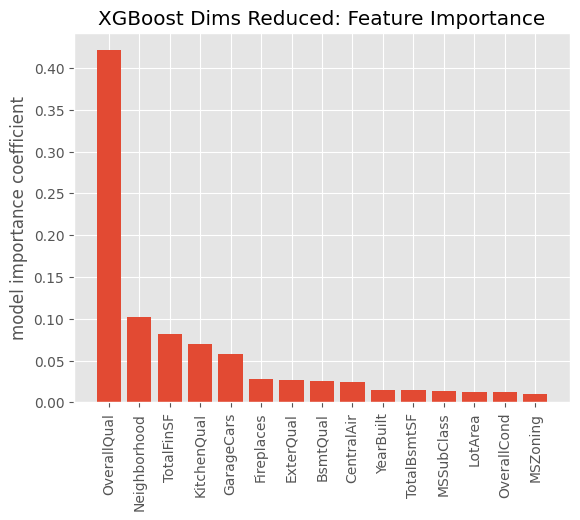

In [285]:
# Extract feature importance from best xgb model
xgb_feature_importances = best_xgb_pipeline.named_steps['regressor'].feature_importances_

target_encoded_feature = ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
                          'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S']

# Get numeric feature names
numeric_features = X.select_dtypes(exclude=['object']).columns

# Combine all feature names
all_features = np.concatenate([target_encoded_feature, numeric_features])

# Map feature importance to feature names
feature_importance_dict = dict(zip(all_features, xgb_feature_importances))

# Sort by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

xgb_feature_importance = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'], index=None)

# Plot Feature Importance - top 15
import matplotlib.pyplot as plt

xgb_importance_15 = xgb_feature_importance.head(15)
plt.bar(xgb_importance_15['Feature'], xgb_importance_15['Importance'])
plt.xticks(rotation=90)
plt.ylabel('model importance coefficient')
plt.title("XGBoost Dims Reduced: Feature Importance")
plt.show()


In [286]:
X_train_preprocessed.shape

(1789, 44)

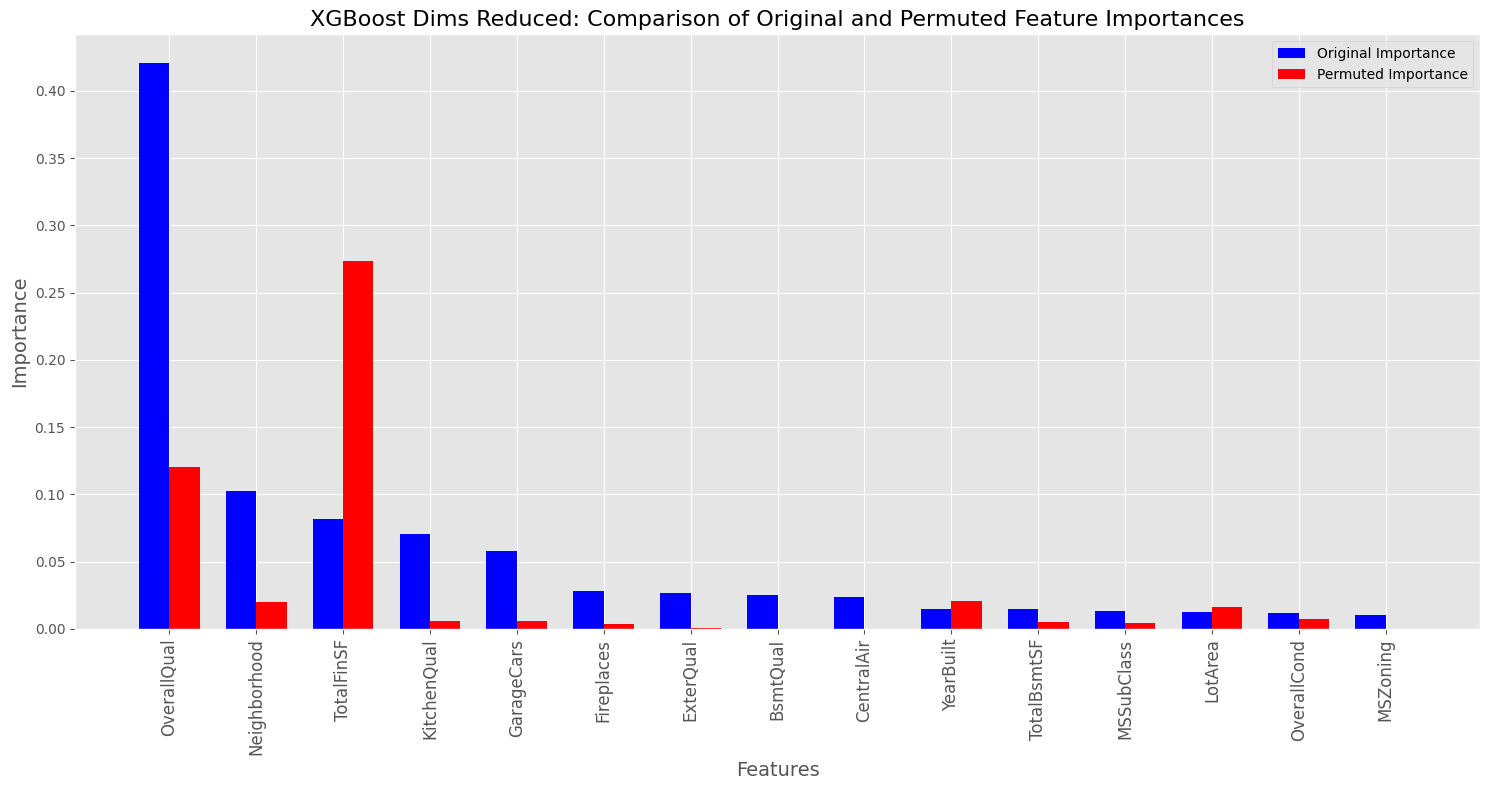

In [287]:
# Run permuted feature importance and plot vs model feature importance
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
import joblib

def permuted_feature_importance(pipeline, X_test, y_test):
    baseline_r2 = r2_score(y_test, pipeline.predict(X_test))
    importances = {}

    for feature in X_test.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])

        permuted_r2 = r2_score(y_test, pipeline.predict(X_test_permuted))
        importances[feature] = baseline_r2 - permuted_r2

    return importances

# Calculate permuted feature importance
xgb_permuted_importances = permuted_feature_importance(best_xgb_pipeline, X_test, y_test)

# Convert to DF and sort
xgb_permuted_importances_df = pd.DataFrame.from_dict(xgb_permuted_importances, orient='index', columns=['Importance'])
xgb_permuted_importances_df.sort_values(by='Importance', ascending=False, inplace=True)


# Select top 15 features from model importances for comparison
top_features = xgb_feature_importance.head(15)['Feature']

# Initialize DF to store comparison
comparison_importances = pd.DataFrame(index=top_features)

# Get the model importance for top features
comparison_importances['Original Importance'] = xgb_feature_importance.set_index('Feature').reindex(top_features)['Importance']

# Get permuted importance for top features
comparison_importances['Permuted Importance'] = xgb_permuted_importances_df.reindex(top_features)['Importance']

# Plot
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.35
index = np.arange(len(top_features))

# Side by side bars
ax.bar(index, comparison_importances['Original Importance'], bar_width, label='Original Importance', color='b')
ax.bar(index + bar_width, comparison_importances['Permuted Importance'], bar_width, label='Permuted Importance', color='r')

ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)
ax.set_title('XGBoost Dims Reduced: Comparison of Original and Permuted Feature Importances', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(comparison_importances.index, rotation=90, fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()


In [288]:
X_train_preprocessed.shape

(1789, 44)

In [289]:
print(len(X_train.columns))
print(X_train_preprocessed.shape[1])

44
44


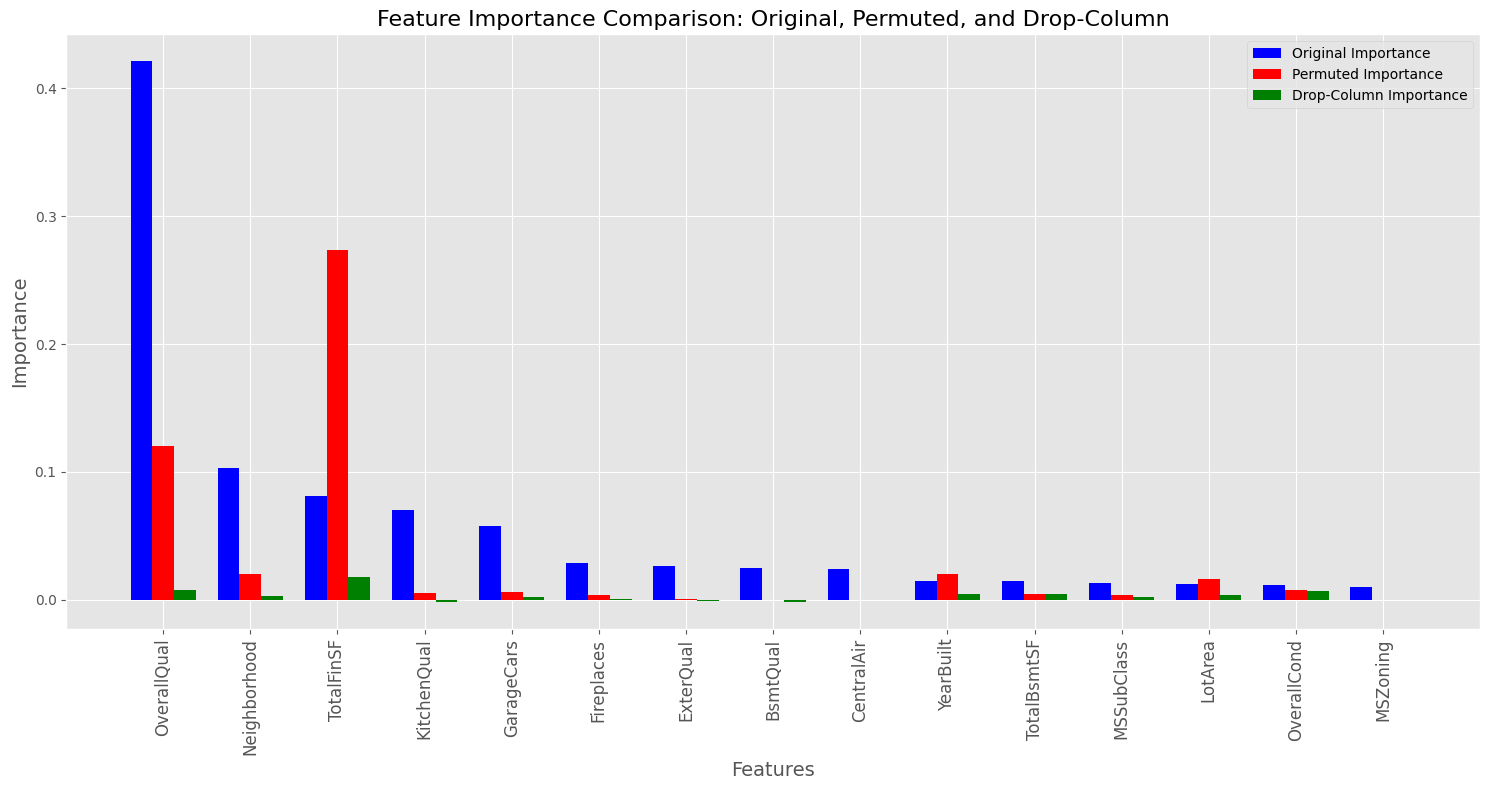

In [290]:
# Calc feature importance by dropping one column and seeing r2 vs baseline r2 with all features

from sklearn.metrics import r2_score
from sklearn.base import clone
import pandas as pd

# correct feature names
correct_feature_names = ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
                         'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'] + list(numeric_features)

# Convert preprocessed data to DF to retain column names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=correct_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=correct_feature_names)

# Define drop-column importance function
def dropcol_importances(model, X_train, y_train, X_test, y_test, feature_names):
    baseline = r2_score(y_test, model.predict(X_test))
    importances = {}

    for col in feature_names:
        X_train_dropped = X_train.drop(columns=col)
        X_test_dropped = X_test.drop(columns=col)
        model_ = clone(model)
        model_.fit(X_train_dropped, y_train)
        score = r2_score(y_test, model_.predict(X_test_dropped))
        importances[col] = baseline - score
    
    return importances

# Clone model from pipeline
model_clone = clone(best_xgb_pipeline.named_steps['regressor'])

# Fit cloned model
model_clone.fit(X_train_preprocessed_df, y_train)

# Calc drop-column feature importance
xgb_dropcol_importances = dropcol_importances(model_clone, X_train_preprocessed_df, y_train, X_test_preprocessed_df, y_test, correct_feature_names)

# Convert to DF
xgb_dropcol_importances_df = pd.DataFrame.from_dict(xgb_dropcol_importances, orient='index', columns=['Importance'])
xgb_dropcol_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Add drop-column importances to the comparison DF
comparison_importances['Drop-Column Importance'] = xgb_dropcol_importances_df.reindex(top_features)['Importance']

# Plot
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.25
index = np.arange(len(top_features))

ax.bar(index, comparison_importances['Original Importance'], bar_width, label='Original Importance', color='b')
ax.bar(index + bar_width, comparison_importances['Permuted Importance'], bar_width, label='Permuted Importance', color='r')
ax.bar(index + 2 * bar_width, comparison_importances['Drop-Column Importance'], bar_width, label='Drop-Column Importance', color='g')

ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)
ax.set_title('Feature Importance Comparison: Original, Permuted, and Drop-Column', fontsize=16)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(comparison_importances.index, rotation=90, fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()


In [291]:
X_train_preprocessed.shape

(1789, 44)

In [292]:
print(len(correct_feature_names))
print(X_train_preprocessed.shape[1])


44
44


In [293]:
# Check accuracy drop-column feature importance by removing important features before processing - this checked out with TotalFinSF & OverallQual

ames_dimreduced_exTSF = ames_dimreduced.drop('OverallQual', axis=1)

X = ames_dimreduced_exTSF.drop('SalePrice', axis=1)
y = ames_dimreduced_exTSF['SalePrice']


# Define target encoder 
target_encoder = ce.TargetEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])

# Define transformer for target encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_encoder, ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])
    ], remainder='passthrough'
)

best_params_xgb = random_search.best_params_

# Create a pipeline 
best_xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=best_params_xgb['regressor__n_estimators'],
                                   learning_rate=best_params_xgb['regressor__learning_rate'],
                                   max_depth=best_params_xgb['regressor__max_depth'],
                                   min_child_weight=best_params_xgb['regressor__min_child_weight'],
                                   gamma=best_params_xgb['regressor__gamma'],
                                   subsample=best_params_xgb['regressor__subsample'],
                                   colsample_bytree=best_params_xgb['regressor__colsample_bytree'],
                                   random_state=42))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)


# Fit 
best_xgb_pipeline.fit(X_train, y_train)

# Predict 
xgb_predictions = best_xgb_pipeline.predict(X_test)

# Calc metrics
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")



RMSE: 20633.480253432994
R-squared: 0.9305944046222917


In [294]:
print(X_train_preprocessed.shape)
print(len(correct_feature_names))
print(X_train_preprocessed.shape[1])


(1789, 44)
44
44


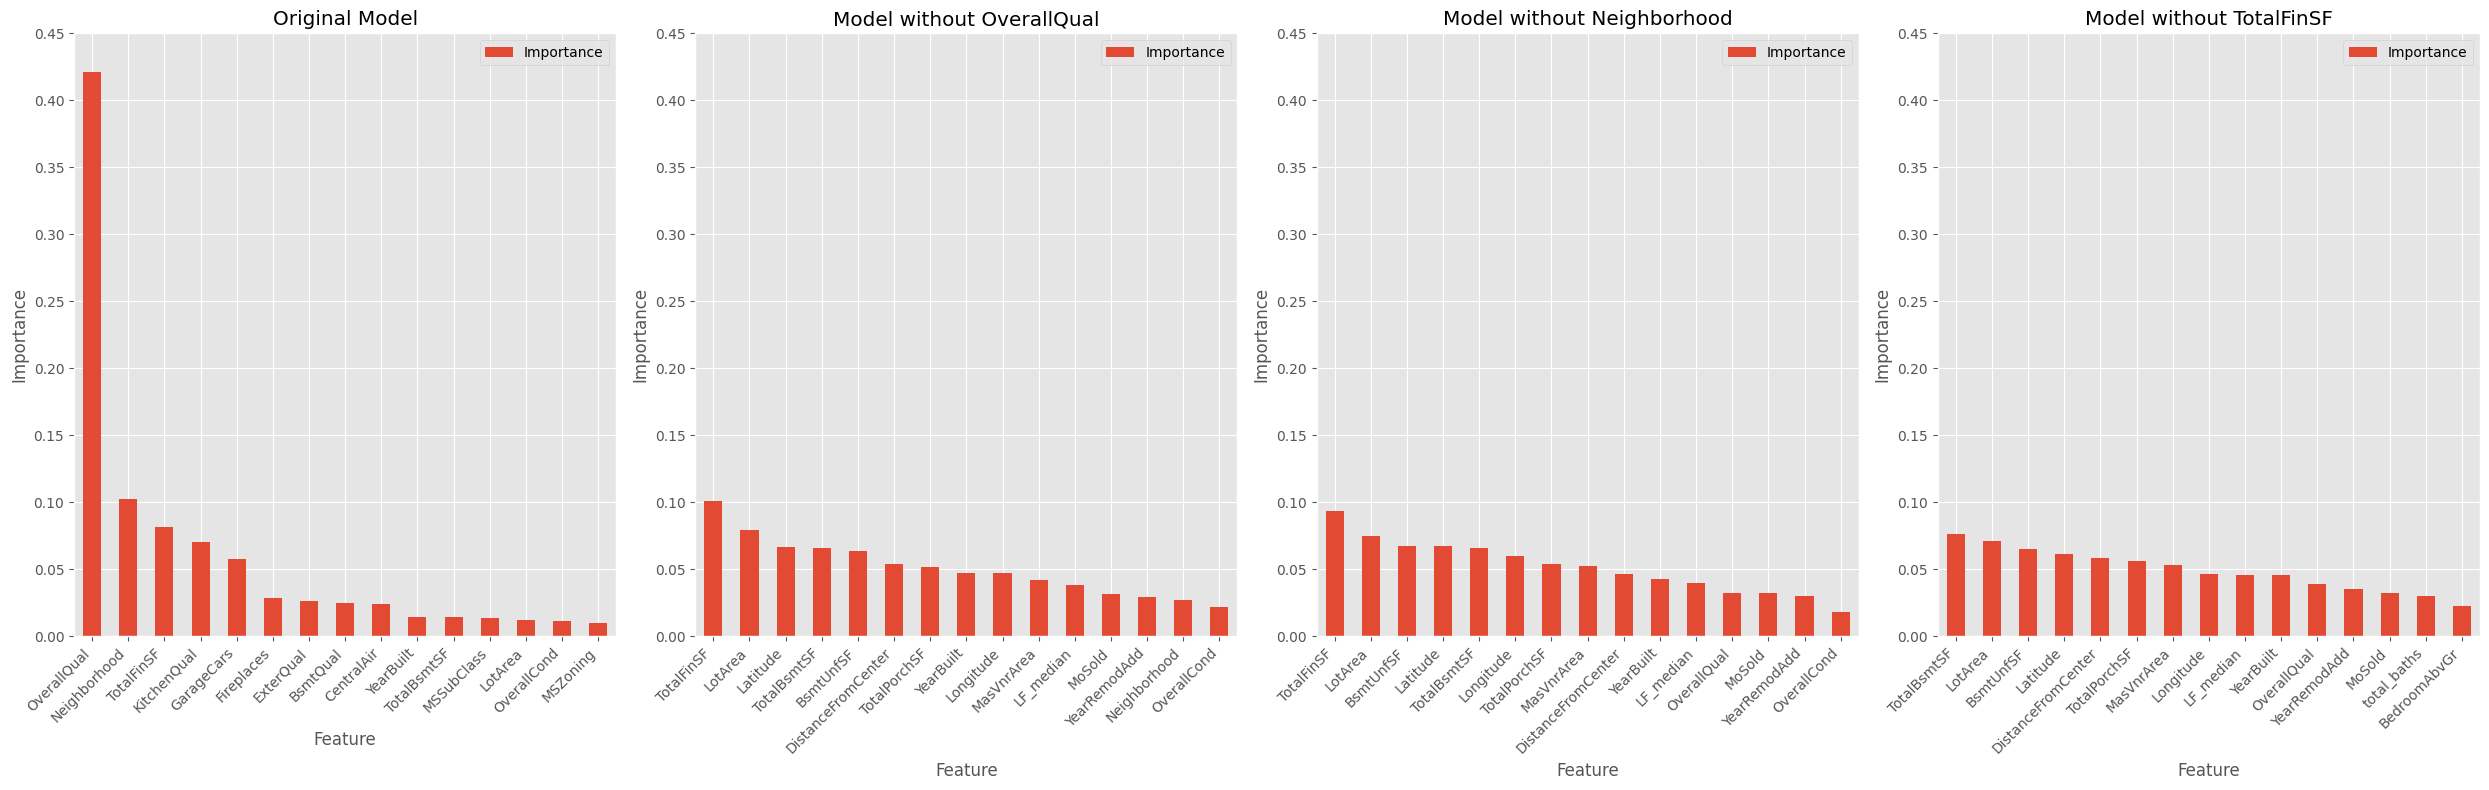

In [295]:
# Plot model feature importance with major features dropped (one at a time)

specific_columns = ['OverallQual', 'Neighborhood', 'TotalFinSF']
dropcol_importances_specific = {}

def model_importances_without_feature(model, X_train, y_train, feature):
    # Drop the specified feature
    X_train_dropped = X_train.drop(columns=feature)

    # Clone and fit the model with modified dataset
    model_ = clone(model)
    model_.fit(X_train_dropped, y_train)

    # Get the feature importances
    importances = model_.get_booster().get_score(importance_type='weight')

    # Normalize importances
    total_importance = sum(importances.values())
    normalized_importances = {k: v / total_importance for k, v in importances.items()}

    # Transform importances to sorted list
    sorted_importances = sorted(normalized_importances.items(), key=lambda x: x[1], reverse=True)

    return sorted_importances

# Initialize a dictionary to store the importances
importances_without_specific_feature = {}

# Calcul importances for each of the dropped col datasets
for col in specific_columns:
    importances_without_specific_feature[col] = model_importances_without_feature(model_clone, X_train_preprocessed_df, y_train, col)


# Func to get top 15 features from sorted importances
def get_top_15_features(sorted_importances):
    return [feature for feature, _ in sorted_importances[:15]]

# Original top 15 features
original_top_15_features = get_top_15_features(sorted_feature_importance)

# Compare with top 15 features when each specific column is removed
top_15_comparison = {col: get_top_15_features(importances_without_specific_feature[col]) for col in specific_columns}

# Plot
fig, axes = plt.subplots(1, 4, figsize=(25, 8))  # 4 plots: original and 3 for each feature removed

# Plot original model importances
original_importances_df[:15].plot(kind='bar', ax=axes[0], title='Original Model')
axes[0].set_ylim(0, 0.45)  

# Models with specific columns removed
for i, col in enumerate(specific_columns):
    # Convert the list of tuples to DF and set 'Feature' as the index
    specific_importances_df = pd.DataFrame(importances_without_specific_feature[col], columns=['Feature', 'Importance']).set_index('Feature')
    # Plot  feature importances for top 15 features
    specific_importances_df[:15].plot(kind='bar', ax=axes[i+1], title=f'Model without {col}')
    # Set the y-axis limits to be consistent with the original model importances
    axes[i+1].set_ylim(0, 0.45)

# Set labels and titles
for ax in axes:
    ax.set_ylabel('Importance')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [296]:
print(X_train_preprocessed.shape)
print(len(correct_feature_names))
print(X_train_preprocessed.shape[1])


(1789, 44)
44
44


[23:05:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


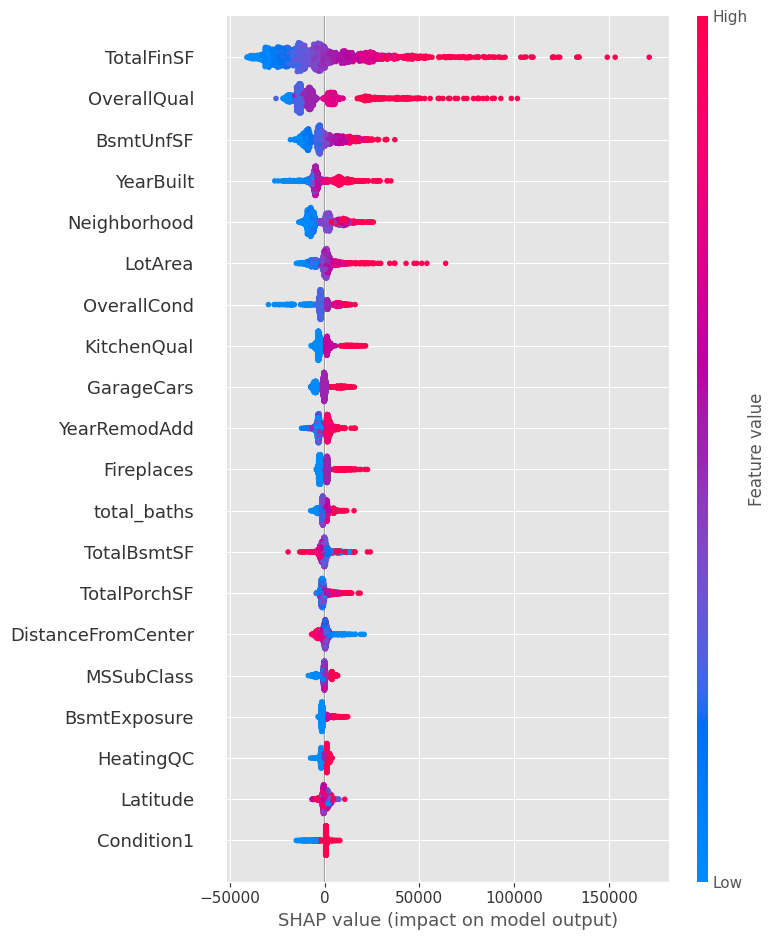

In [297]:
# Get XGBoost SHAP values

import shap
import scipy.sparse 
# xgb_model = best_xgb_pipeline.named_steps['regressor']

# Preprocess 
# X_train_preprocessed = best_xgb_pipeline.named_steps['preprocessor'].transform(X_train)
# 
# Convert one-hot encoded data to dense format
# if isinstance(X_train_preprocessed, scipy.sparse.csr.csr_matrix):
    # X_train_preprocessed = X_train_preprocessed.toarray()
# 

# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_preprocessed)

shap_values = explainer(X_train_preprocessed)

shap.summary_plot(shap_values, X_train_preprocessed, feature_names=correct_feature_names)


In [298]:
print(X_train_preprocessed.shape)
print(len(correct_feature_names))
print(X_train_preprocessed.shape[1])


(1789, 44)
44
44


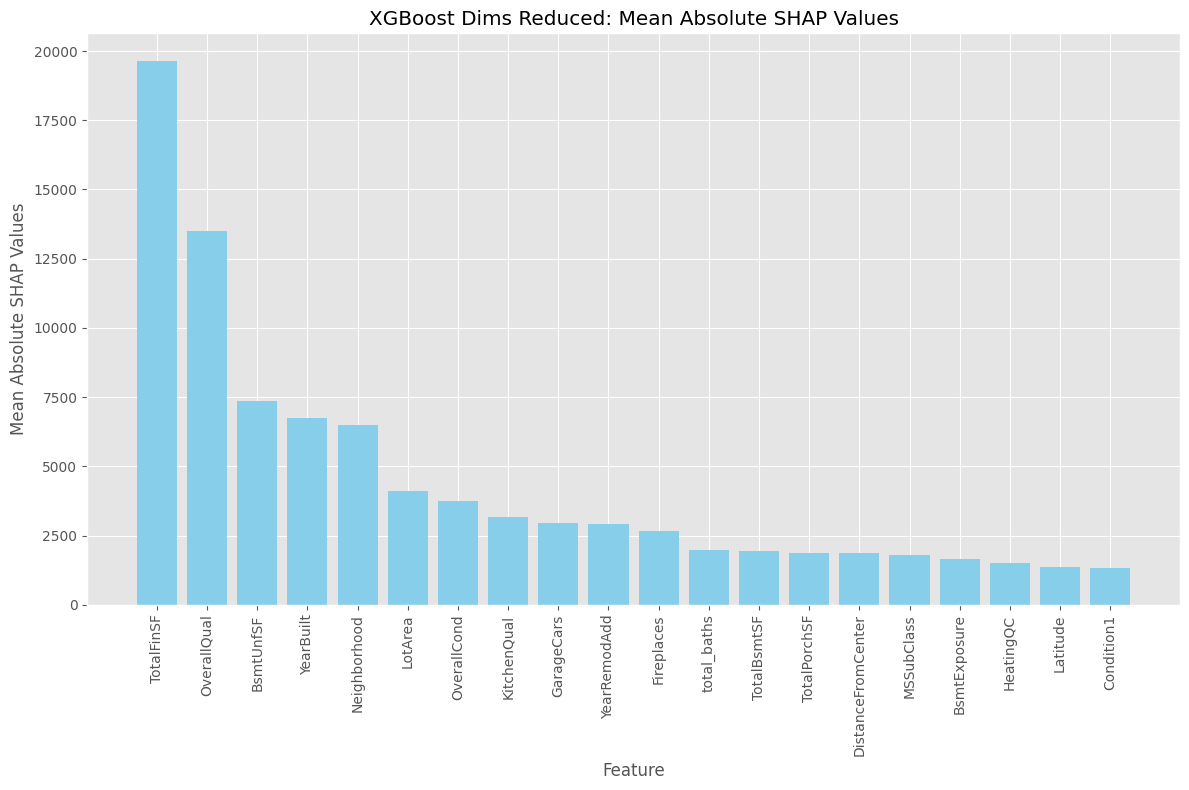

In [300]:
# Plot mean absolute shap values 
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

feature_names = correct_feature_names

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
})

top_features = feature_importance.sort_values(by='mean_abs_shap', ascending=False).head(20)

plt.style.use("ggplot")
# Plot
plt.figure(figsize=(12,8))
plt.bar(top_features['feature'], top_features['mean_abs_shap'], color='skyblue')
plt.ylabel('Mean Absolute SHAP Values')
plt.xlabel('Feature')
plt.title('XGBoost Dims Reduced: Mean Absolute SHAP Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [301]:
print(len(correct_feature_names))
print(len(mean_abs_shap))
print(X_train_preprocessed.shape)
print(correct_feature_names)
print(mean_abs_shap)


44
44
(1789, 44)
['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S', 'LotArea', 'LotShape', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'GarageFinish', 'GarageCars', 'PavedDrive', 'MoSold', 'SaleCondition', 'Latitude', 'Longitude', 'LF_median', 'DistanceFromCenter', 'total_baths', 'TotalPorchSF', 'TotalFinSF']
[ 1807.78665929   894.45350695  6502.16836407  1329.74545864
     0.           384.3160348    204.84371526   914.23717522
    77.33625004     0.          4109.92713196    58.39427698
 13492.72195359  3760.96236818  6740.48033742  2902.75967358
  1256.6169958    287.708557     101.19908665    65.94658056
   517.54968747  1644.3960384    952.21799267  7349.

In [136]:
xgb_permuted_importances_df

,Importance
TotalFinSF,0.238696
OverallQual,0.111580
YearBuilt,0.026407
BsmtUnfSF,0.025286
Neighborhood,0.021955
LotArea,0.010840
OverallCond,0.007882
KitchenQual,0.007186
GarageCars,0.006412
TotalPorchSF,0.006392


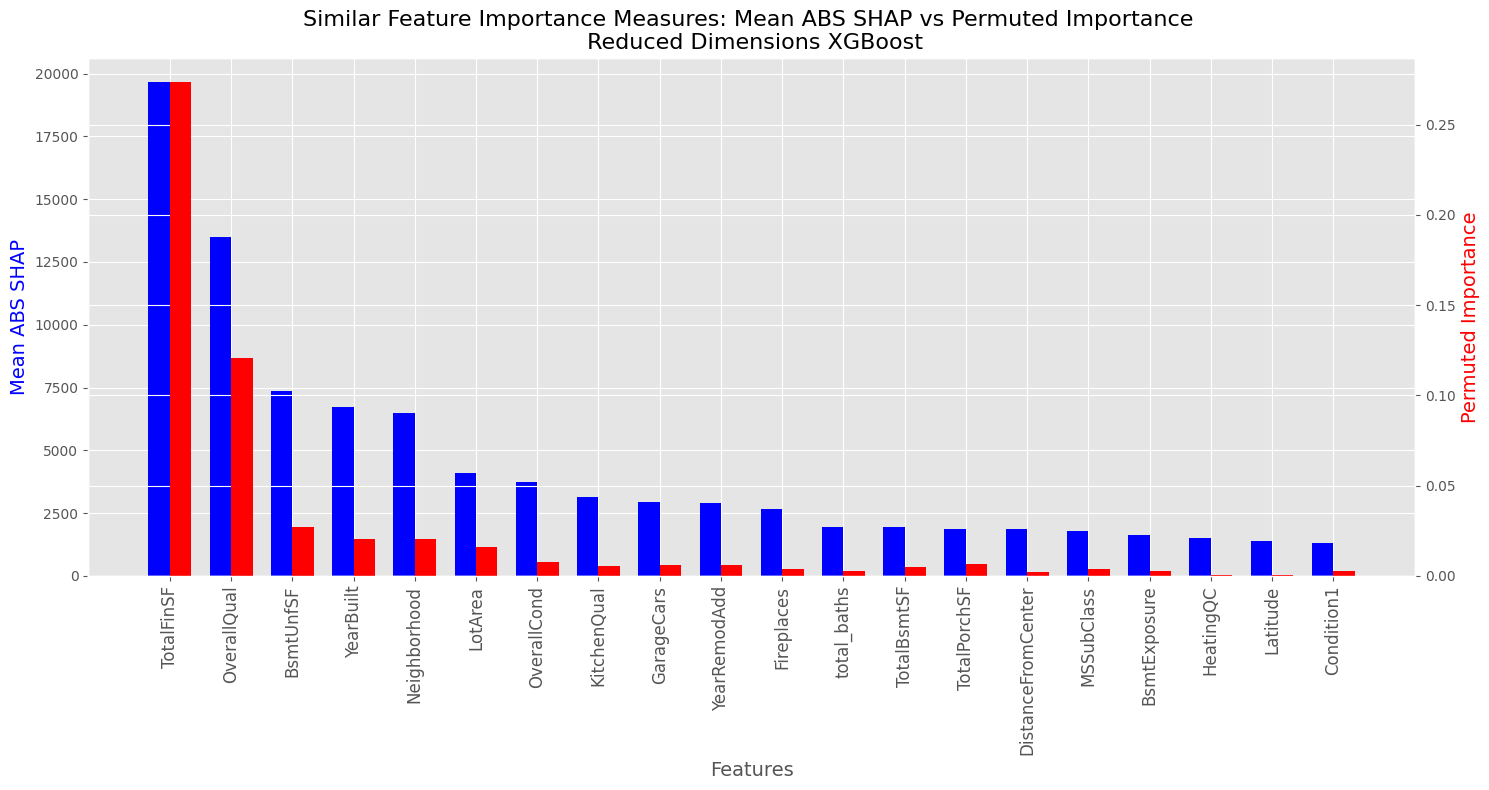

In [302]:
# Plot Mean ABS SHAP against Permuted Importance
full_importances = feature_importance.merge(
    xgb_permuted_importances_df['Importance'],
    left_on='feature',
    right_index=True,
    how = 'left'
)

full_importances.sort_values(by='mean_abs_shap', ascending=False, inplace=True)
full_importances_20 = full_importances.head(20)

#Plot
fig, ax1 = plt.subplots(figsize=(15,8))

width = 0.35 

ind = np.arange(len(full_importances_20)) 


ax1.bar(ind - width/2, full_importances_20['mean_abs_shap'], width, color='blue', label='Mean ABS SHAP')

ax2 = ax1.twinx()
ax2.bar(ind + width/2, full_importances_20['Importance'], width, color='red', label='Permuted Importance')

ax1.set_xlabel('Features', fontsize=14)
ax1.set_ylabel('Mean ABS SHAP', fontsize=14, color='b')
ax2.set_ylabel('Permuted Importance', fontsize=14, color='r')

plt.title('Similar Feature Importance Measures: Mean ABS SHAP vs Permuted Importance \n Reduced Dimensions XGBoost', fontsize=16)

ax1.set_xticks(range(len(full_importances_20)))
ax1.set_xticklabels(full_importances_20['feature'], rotation=90, fontsize=12)

plt.tight_layout()
plt.show()

In [155]:
full_importances

,feature,mean_abs_shap,Importance
43,TotalFinSF,19656.839398,0.238696
12,OverallQual,13492.721954,0.111580
23,BsmtUnfSF,7349.390626,0.025286
14,YearBuilt,6740.480337,0.026407
2,Neighborhood,6502.168364,0.021955
10,LotArea,4109.927132,0.010840
13,OverallCond,3760.962368,0.007882
29,KitchenQual,3160.999137,0.007186
33,GarageCars,2945.932919,0.006412
15,YearRemodAdd,2902.759674,0.006206


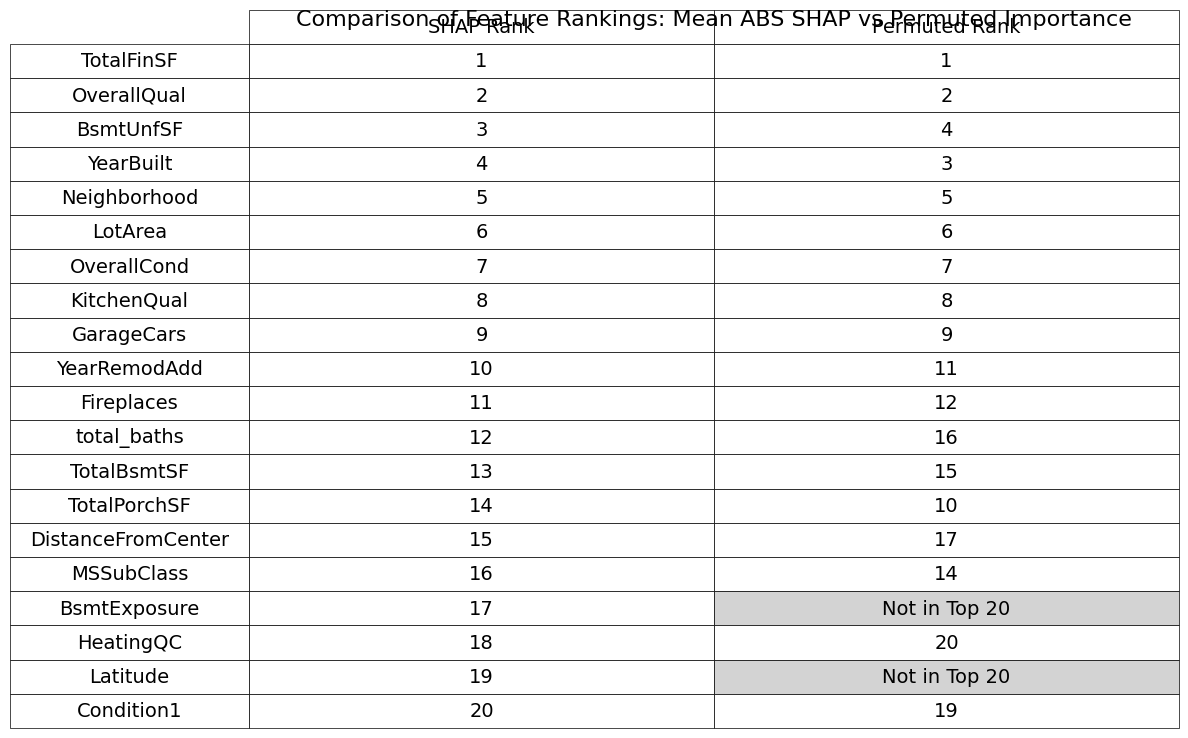

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'full_importances' is your DataFrame with columns ['feature', 'mean_abs_shap', 'Importance']
# First, rank features based on 'mean_abs_shap' and 'Importance'
full_importances['shap_rank'] = full_importances['mean_abs_shap'].rank(ascending=False, method='min')
full_importances['permuted_rank'] = full_importances['Importance'].rank(ascending=False, method='min')

# Convert ranks to integers
full_importances['shap_rank'] = full_importances['shap_rank'].astype(int)
full_importances['permuted_rank'] = full_importances['permuted_rank'].astype(int)

# For display, replace ranks outside the top 20 with the string 'Not in Top 20'
full_importances['shap_rank_display'] = full_importances.apply(lambda x: x['shap_rank'] if x['shap_rank'] <= 20 else 'Not in Top 20', axis=1)
full_importances['permuted_rank_display'] = full_importances.apply(lambda x: x['permuted_rank'] if x['permuted_rank'] <= 20 else 'Not in Top 20', axis=1)

# Create a DataFrame for display purposes
ranks_for_display = full_importances[['feature', 'shap_rank_display', 'permuted_rank_display']].copy()
ranks_for_display.set_index('feature', inplace=True)

# Sort by 'shap_rank' to get the top features according to SHAP
ranks_for_display.sort_values(by='shap_rank_display', inplace=True, key=lambda col: col.replace('Not in Top 20', 21).astype(int))

# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Comparison of Feature Rankings: Mean ABS SHAP vs Permuted Importance', fontsize=16, pad=20)

# Create the table
cell_text = ranks_for_display.head(20).values.tolist()
cell_colors = [['white' if isinstance(val, int) else 'lightgrey' for val in row] for row in cell_text]

# Create the table
table = plt.table(cellText=cell_text, cellColours=cell_colors,
                  rowLabels=ranks_for_display.head(20).index,
                  colLabels=['SHAP Rank', 'Permuted Rank'],
                  loc='center', cellLoc='center', rowLoc='center')

# Modify table properties
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)

# Remove chart elements
ax.axis('off')

# Adjust layout to make room for the title
plt.subplots_adjust(top=0.9)

plt.show()


In [145]:
full_importances

,feature,mean_abs_shap,Importance
43,TotalFinSF,19656.839398,0.238696
12,OverallQual,13492.721954,0.111580
23,BsmtUnfSF,7349.390626,0.025286
14,YearBuilt,6740.480337,0.026407
2,Neighborhood,6502.168364,0.021955
10,LotArea,4109.927132,0.010840
13,OverallCond,3760.962368,0.007882
29,KitchenQual,3160.999137,0.007186
33,GarageCars,2945.932919,0.006412
15,YearRemodAdd,2902.759674,0.006206


In [108]:
import shap
import numpy as np
import pandas as pd
from sklearn.base import clone

def compute_mean_abs_shap_for_dropped_feature(model, X_train, y_train, dropped_feature, baseline_mean_abs_shap, all_features):
    # Drop the feature from the training data
    X_train_dropped = X_train.drop(columns=dropped_feature)
    model_clone = clone(model)
    model_clone.fit(X_train_dropped, y_train)
    explainer = shap.Explainer(model_clone, X_train_dropped)
    shap_values_dropped = explainer(X_train_dropped)

    # Calculate mean absolute SHAP values for the model with the dropped feature
    dropped_shap_mean = np.abs(shap_values_dropped.values).mean(axis=0)
    
    # Align and calculate the absolute change in mean SHAP values
    aligned_baseline_shap = np.array([baseline_mean_abs_shap[all_features.index(feature)] for feature in X_train_dropped.columns])
    abs_change_in_shap = np.abs(aligned_baseline_shap - dropped_shap_mean)

    # Map the absolute change in SHAP values back to the original features
    abs_change_in_shap_dict = {feature: abs_change_in_shap[i] for i, feature in enumerate(X_train_dropped.columns)}
    # Add zero change for the dropped feature
    abs_change_in_shap_dict[dropped_feature] = 0

    return abs_change_in_shap_dict

def shap_dropcol_importances(model, X_train_preprocessed, y_train, feature_names):
    # Fit the model and create the SHAP explainer
    model.fit(X_train_preprocessed, y_train)
    explainer = shap.Explainer(model, X_train_preprocessed)
    shap_values_baseline = explainer(X_train_preprocessed)
    
    # Calculate mean absolute SHAP values for the baseline model
    baseline_mean_abs_shap = np.abs(shap_values_baseline.values).mean(axis=0)
    all_features = X_train_preprocessed.columns.tolist()

    # Initialize a list to store results
    results = []

    # Compute the absolute change in mean SHAP values for each feature when it is dropped
    for col in feature_names:
        if col in all_features:
            abs_change_in_shap = compute_mean_abs_shap_for_dropped_feature(model, X_train_preprocessed, y_train, col, baseline_mean_abs_shap, all_features)
            results.append(abs_change_in_shap)
    
    print(results)

    # Convert the list of dictionaries to a DataFrame
    shap_importance_changes_df = pd.DataFrame(results, index=feature_names)

    return shap_importance_changes_df

# Calculate SHAP values with each feature dropped
shap_importance_changes_df = shap_dropcol_importances(model_clone, X_train_preprocessed_df, y_train, correct_feature_names)


[17:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-au

[{'MSZoning': 137.48875903708085, 'Neighborhood': 966.9029707078516, 'Condition1': 62.44141159094556, 'Condition2': 0.0, 'HouseStyle': 401.755342557649, 'RoofStyle': 165.5096179971703, 'Exterior1st': 103.98870590097226, 'Electrical': 29.541987524704275, 'ClassPr_S': 0.0, 'LotArea': 773.6615410844624, 'LotShape': 32.263593064676655, 'OverallQual': 370.74565893420913, 'OverallCond': 584.118773893626, 'YearBuilt': 636.0324047552958, 'YearRemodAdd': 220.6502913705972, 'MasVnrArea': 94.89475410668501, 'ExterQual': 1343.4657802405081, 'ExterCond': 12.510847011931318, 'Foundation': 271.23879734201904, 'BsmtQual': 106.5975044598606, 'BsmtExposure': 338.84496189857305, 'BsmtFinType1': 174.3368578452487, 'BsmtUnfSF': 516.8566905573807, 'TotalBsmtSF': 286.61870098770237, 'HeatingQC': 306.02230402855344, 'CentralAir': 6.175504782412645, 'LowQualFinSF': 4.148991627146771, 'BedroomAbvGr': 36.324770355507894, 'KitchenQual': 963.7915176477622, 'Functional': 14.498522374065487, 'Fireplaces': 499.676278

In [111]:
shap_importance_changes_df.to_csv("dropcol_SHAPs_1.csv")

[12:15:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


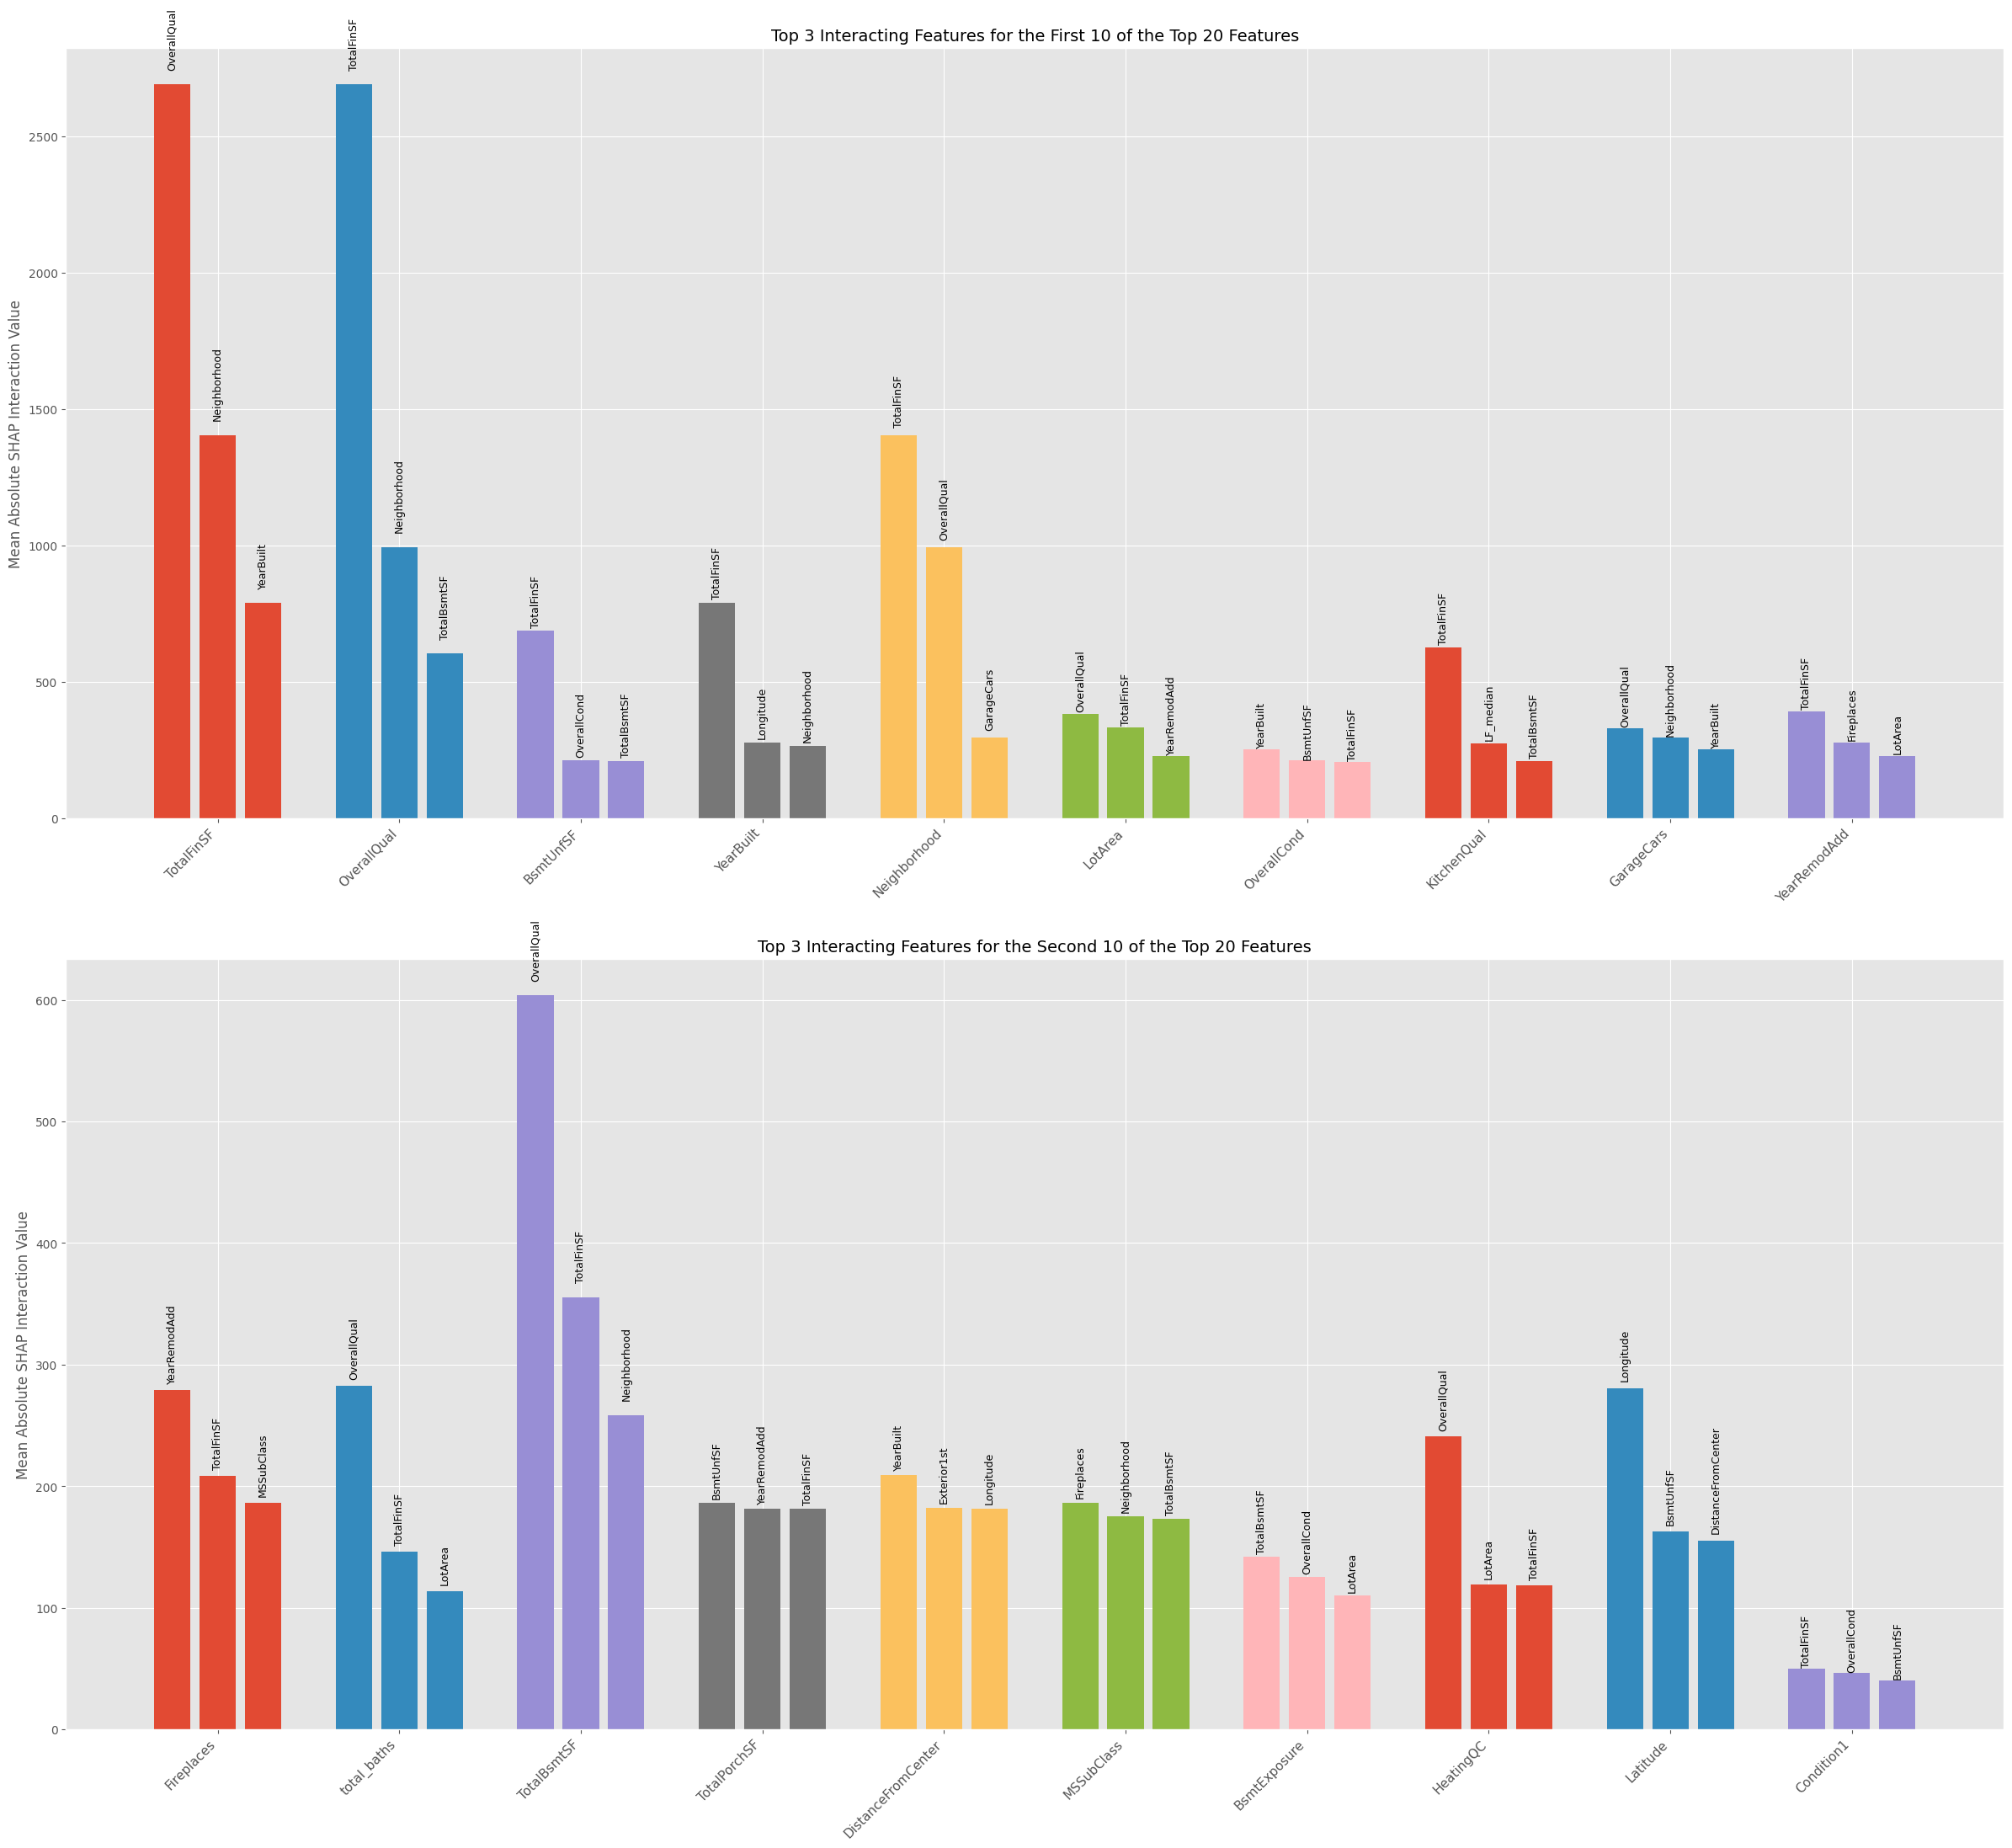

In [60]:
# Create and plot top 3 interaction features for each of the top 20 XGB model features (by mean abs SHAP val)

xgb_model = best_xgb_pipeline.named_steps['regressor']

# Create SHAP explainer 
explainer = shap.Explainer(xgb_model, feature_names=correct_feature_names)

# Calc interaction values
interaction_values = explainer.shap_interaction_values(X_train_preprocessed)

# Calc mean interaction values across all samples
mean_interaction_values = np.abs(interaction_values).mean(axis=0)

top_20_feature_names = top_features['feature'].head(20).tolist()

# Initialize a dictionary to hold the top 3 interactions for each feature
top_interactions = {}

# Iterate over each of the top 20 features
for feature in top_20_feature_names:
    # Get the index of the feature
    feature_idx = correct_feature_names.index(feature)
    
    # Get the interaction values of this feature with all other features
    feature_interactions = mean_interaction_values[feature_idx, :]
    
    # Get the top 3 interactions excluding  self-interaction
    top_3_idx = np.argsort(feature_interactions)[-4:-1]  # Exclude last one: the feature itself
    top_3_features = [correct_feature_names[i] for i in top_3_idx]
    top_3_values = feature_interactions[top_3_idx]

    # Store in dictionary
    top_interactions[feature] = (top_3_features, top_3_values)

import matplotlib.pyplot as plt

# Create func for plotting
def plot_feature_interactions(interactions_dict, features, ax):
    for i, feature in enumerate(features):
        # Get the top 3 interactions for the feature
        interacting_features, values = interactions_dict[feature]
        sorted_idx = np.argsort(values)[::-1]  # Sort the values in descending order
        values = values[sorted_idx]

        # Convert sorted_idx to a list for indexing
        sorted_idx_list = sorted_idx.tolist()
        
        # Use the list to index interacting_features
        interacting_features = [interacting_features[j] for j in sorted_idx_list]

        # Position of bars for this feature
        bar_positions = np.array(range(i*4, i*4 + 3))
        
        # Plot the bars
        ax.bar(bar_positions, values)

        # Annotate bars with feature names
        for pos, val, interact_feature in zip(bar_positions, values, interacting_features):
            ax.text(pos, val + 0.02 * max(values), interact_feature, ha='center', va='bottom', rotation=90, fontsize=9)

    # Set the x-ticks to be in the middle of each group of bars
    ax.set_xticks([i*4 + 1 for i in range(len(features))])
    ax.set_xticklabels(features, rotation=45, ha='right', fontsize=11)
    ax.set_ylabel('Mean Absolute SHAP Interaction Value', fontsize=12)


# Split the top 20 features into two groups of 10
first_10_features = list(top_20_feature_names)[:10]
second_10_features = list(top_20_feature_names)[10:]

# Create subplots 
fig, axs = plt.subplots(2, 1, figsize=(24, 24)) # gridspec_kw={'hspace': 0.6})  # Adjust horizontal spacing

# Plot interactions for the first 10 features
plot_feature_interactions(top_interactions, first_10_features, axs[0])
axs[0].set_title('Top 3 Interacting Features for the First 10 of the Top 20 Features', fontsize=14)

# Plot interactions for the second 10 features
plot_feature_interactions(top_interactions, second_10_features, axs[1])
axs[1].set_title('Top 3 Interacting Features for the Second 10 of the Top 20 Features', fontsize=14)

# Show the plot with adjusted layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


[10:28:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:28:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:28:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-au

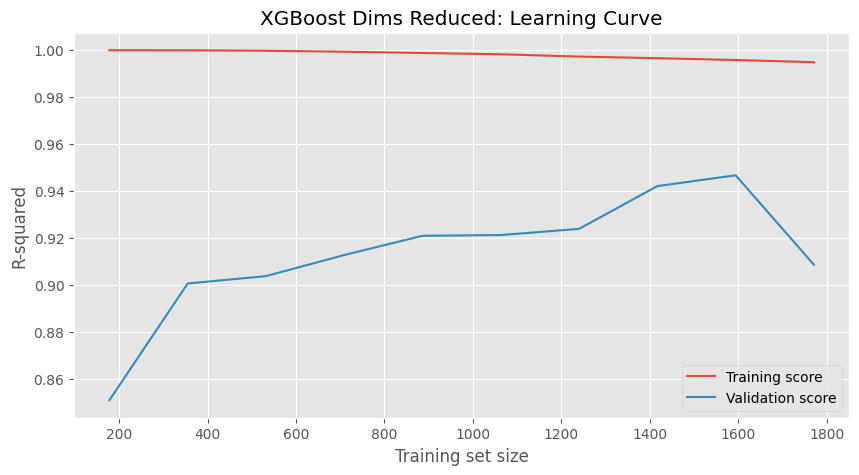

In [11]:
# Learning Curve - see how model improves with more data - also get SHAP as I train

from sklearn.metrics import mean_squared_error, r2_score

def compute_shap_values(pipeline, X_train, y_train, X_val):
    pipeline.fit(X_train, y_train)
    model = pipeline.named_steps['regressor']
   
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_transformed)

    # Compute mean SHAP values
    mean_shap_values = np.mean(shap_values, axis=0)
    
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    return pd.DataFrame({'feature': transformed_feature_names, 'mean_shap_value': mean_shap_values})

# Lists to store results
train_sizes = []
train_scores = []
validation_scores = []
shap_values_dfs = []

# Define range of training set sizes 
for frac in np.linspace(0.1, 0.99, 10):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    # Calc SHAP vals per subset
    shap_df = compute_shap_values(best_xgb_pipeline, X_train_sub, y_train_sub, X_val_sub)    
    shap_values_dfs.append(shap_df)
    
    # Store training set size
    train_sizes.append(X_train_sub.shape[0])

    # Evaluate model by set size
    train_predictions = best_xgb_pipeline.predict(X_train_sub)
    train_score = r2_score(y_train_sub, train_predictions)
    train_scores.append(train_score)

    # Evaluate on validation set
    val_predictions = best_xgb_pipeline.predict(X_val_sub)
    val_score = r2_score(y_val_sub, val_predictions)
    validation_scores.append(val_score)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_scores, label='Training score')
plt.plot(train_sizes, validation_scores, label='Validation score')
plt.ylabel('R-squared')
plt.xlabel('Training set size')
plt.title('XGBoost Dims Reduced: Learning Curve')
plt.legend()
plt.show()
    

[10:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-au

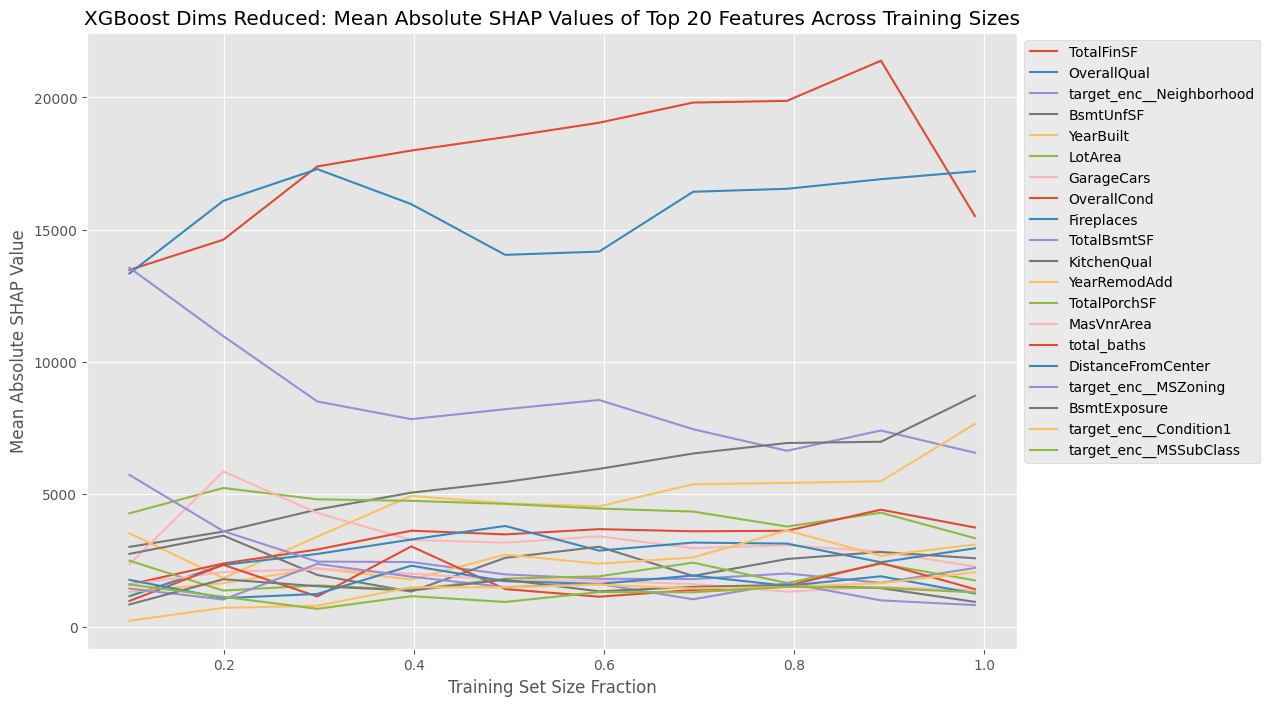

In [12]:
# Now plot the changes in SHAP values per training set size

# Function to calc abs SHAP values and pair with feature names
def compute_absolute_shap_values(pipeline, X_train, y_train, X_val):
    pipeline.fit(X_train, y_train)
    model = pipeline.named_steps['regressor']
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_transformed)

    abs_shap_values = np.abs(shap_values)
    
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    return pd.DataFrame(abs_shap_values, columns=transformed_feature_names)

# Lists to store results
train_sizes = []
shap_values_aggregated = pd.DataFrame()

# Compute mean abs SHAP vals per training set size model
for frac in np.linspace(0.1, 0.99, 10):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    abs_shap_df = compute_absolute_shap_values(best_xgb_pipeline, X_train_sub, y_train_sub, X_val_sub)
    shap_values_aggregated[frac] = abs_shap_df.mean()

    train_sizes.append(X_train_sub.shape[0])

# Convert fractions to consistent format (e.g., string) for df column names
train_sizes_str = [str(size) for size in train_sizes]

# Get top 20 features
top_features = shap_values_aggregated.mean(axis=1).nlargest(20).index

# Remove prefix from feature names
top_features_cleaned = top_features.str.replace('^cat__|^remainder__', '', regex=True)

# Initialize df 
top_features_shap_values = pd.DataFrame(index=top_features_cleaned)

# Populate df with mean abs SHAP values for top features across all training sizes
for size in shap_values_aggregated.columns:
    for feature, cleaned_feature in zip(top_features, top_features_cleaned):
        top_features_shap_values.at[cleaned_feature, size] = shap_values_aggregated.at[feature, size]

# Plot
plt.figure(figsize=(12, 8))
for feature in top_features_shap_values.index:
    plt.plot(shap_values_aggregated.columns, top_features_shap_values.loc[feature, :], label=feature)

plt.xlabel('Training Set Size Fraction')
plt.ylabel('Mean Absolute SHAP Value')
plt.title('XGBoost Dims Reduced: Mean Absolute SHAP Values of Top 20 Features Across Training Sizes')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

                          Mean Abs SHAP Value  Std Dev SHAP Value  \
TotalFinSF                       18091.498047         1189.010864   
OverallQual                      17711.021484         1376.290527   
target_enc__Neighborhood          7600.269043          953.975281   
BsmtUnfSF                         5457.059082          445.174316   
YearBuilt                         4586.642578          919.048096   
LotArea                           4225.634277          476.385803   
OverallCond                       3462.356934          311.979584   
YearRemodAdd                      3011.064697          627.389587   
GarageCars                        2983.216309          557.490295   
Fireplaces                        2929.504883          465.252075   

                                  2.5%         97.5%  
TotalFinSF                16023.445728  20583.733398  
OverallQual               14721.596387  20224.204883  
target_enc__Neighborhood   5733.222034   9502.543018  
BsmtUnfSF           

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


<Figure size 1200x700 with 0 Axes>

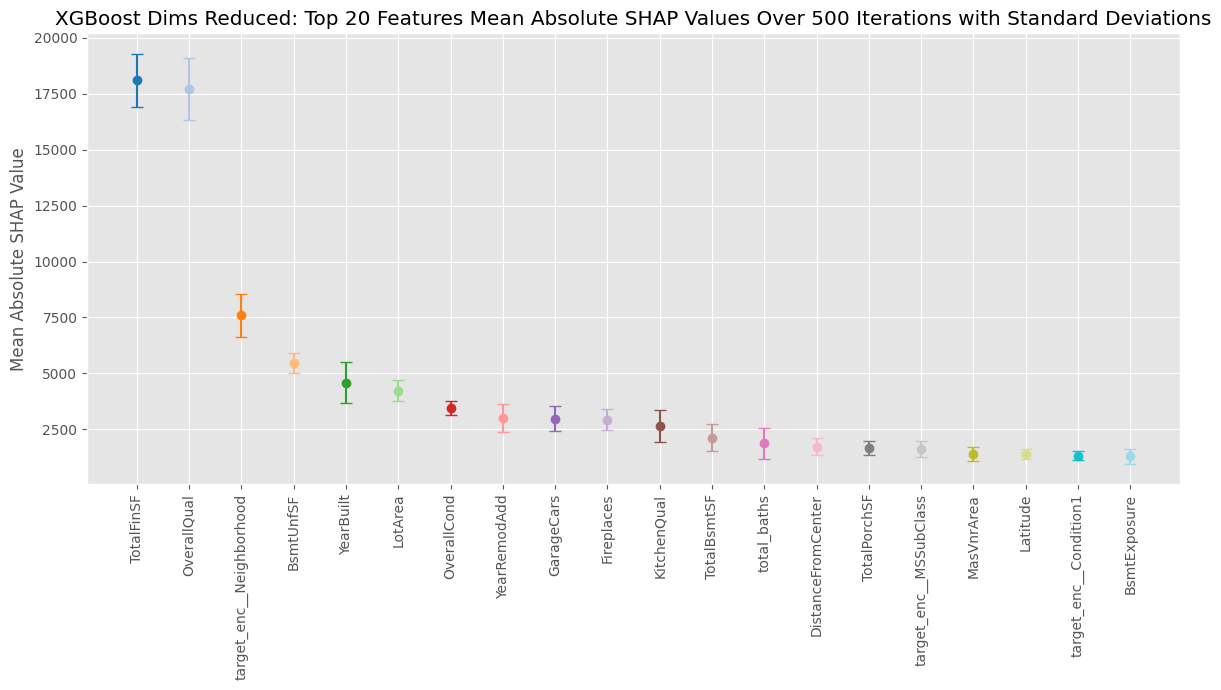

In [13]:
# Calc mean abs shap values per feature over 500 boostrapping iterations and see avgs and st devs for variability

from joblib import Parallel, delayed
from sklearn.utils import resample

# Use the pipeline that includes the XGBoost regressor and preprocessing
xgb_pipeline = best_xgb_pipeline

# Define a function to compute SHAP values on bootstrap samples
def compute_bootstrap_shap_values(X, y, pipeline, n):
    import shap
    from sklearn.utils import resample

    # Resample the data
    X_sample, y_sample = resample(X, y, replace=True)
    
    # Train the pipeline on the resampled data
    pipeline.fit(X_sample, y_sample)
    
    # Extract the trained model from the pipeline
    trained_model = pipeline.named_steps['regressor']
    
    # Get the preprocessed features from the pipeline
    X_sample_transformed = pipeline.named_steps['preprocessor'].transform(X_sample)

    print(f"Computing SHAP values for bootstrap sample ...")

    # Create SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(trained_model)
    shap_values = explainer.shap_values(X_sample_transformed)

    # Calculate the mean absolute SHAP values
    mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
    
    # Retrieve feature names
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Return the mean SHAP values along with feature names
    return pd.Series(mean_abs_shap_values, index=feature_names)

# Number of bootstrapping iterations
n_iterations = 500
n_jobs = -1  # Use all available cores

# Perform the bootstrap calculations
bootstrap_results = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(compute_bootstrap_shap_values)(X_train, y_train, xgb_pipeline, len(y_train)) for i in range(n_iterations)
)

# Convert the results to a DataFrame
bootstrap_shap_values = pd.DataFrame(bootstrap_results)

# Calculate the mean and standard deviation of the SHAP values
mean_abs_shap_values = bootstrap_shap_values.mean(axis=0)
std_shap_values = bootstrap_shap_values.std(axis=0)

# Calculate the confidence intervals
conf_intervals = bootstrap_shap_values.quantile([0.025, 0.975], axis=0).T
conf_intervals.columns = ['2.5%', '97.5%']

# Combine mean, std, and confidence intervals into one DataFrame
xgb_shap_stats = pd.DataFrame({
    'Mean Abs SHAP Value': mean_abs_shap_values, 
    'Std Dev SHAP Value': std_shap_values
}).join(conf_intervals)


# Sort the features by the absolute mean SHAP value
xgb_shap_stats = xgb_shap_stats.reindex(mean_abs_shap_values.abs().sort_values(ascending=False).index)
xgb_shap_stats.index = xgb_shap_stats.index.str.replace('remainder__', '')

# Print the top 10 features for inspection
print(xgb_shap_stats.head(10))

# Now you can use mean_shap_values and conf_intervals as needed for further analysis or plotting
top_20_features = xgb_shap_stats['Mean Abs SHAP Value'].abs().sort_values(ascending=False).head(20).index

# Plot mean of top ten most impactful features with std dev
plt.figure(figsize=(12, 7))

top_20_features = xgb_shap_stats.head(20)

# Generate a list of colors
colors = plt.cm.tab20(np.linspace(0, 1, 20))

plt.figure(figsize=(12, 7))

# Plot each feature with a unique color
for i, (feature_name, row) in enumerate(top_20_features.iterrows()):
    plt.errorbar(i, row['Mean Abs SHAP Value'], yerr=row['Std Dev SHAP Value'], fmt='o', capsize=4, color=colors[i], label=feature_name)

plt.xticks(range(len(top_20_features)), top_20_features.index, rotation=90)
plt.ylabel('Mean Absolute SHAP Value')
plt.title('XGBoost Dims Reduced: Top 20 Features Mean Absolute SHAP Values Over 500 Iterations with Standard Deviations')

# Create a custom legend
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

--------------------------------------------------------------Random Forest--------------------------------------------------

In [14]:
# Run Random Forest wtarget encoding and pipeline creation

from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Set up new pipeline for cross validation

# Define dataset
X = ames_dimreduced.drop('SalePrice', axis=1)
y = ames_dimreduced['SalePrice']

# Define transformer for one-hot encoding (excluding 'Neighborhood')
# categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# categorical_features.remove('MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2','HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S')

# Define target encoder 
target_encoder = ce.TargetEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])

# Define transformer for target encoding
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_encoder, ['MSSubClass', 'MSZoning', 'Neighborhood', 'Condition1', 'Condition2',
'HouseStyle', 'RoofStyle', 'Exterior1st', 'Electrical', 'ClassPr_S'])
    ], remainder='passthrough'
)

# Create a pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', rf_preprocessor),
                           ('regressor', RandomForestRegressor(criterion='squared_error', random_state=42))])

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Fit the pipeline
rf_pipeline.fit(X_train, y_train)

# Access the RandomForestRegressor from the pipeline and print its parameters
random_forest_model = rf_pipeline.named_steps['regressor']
print("Random Forest hyperparameters:")
print(random_forest_model.get_params())

# Evaluate model
rf_predictions = rf_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, rf_predictions)
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

# Perform CV
scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", scores)


Random Forest hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RMSE: 19413.752684620038
R-squared: 0.9097052576675856
Cross-validated R-squared scores: [0.89294795 0.89974756 0.93078259 0.90170197 0.91863084]


In [15]:
# Tune Hyperparams with grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Create pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))])

# Instantiate grid search
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit Grid Search
rf_grid_search.fit(X,y)

print("Best Parameters", rf_grid_search.best_params_)

Best Parameters {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}


In [16]:
# Re-model with best params from first model

rf_final_model = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators= 200,
        max_depth= 20,
        min_samples_split=2,
        random_state=42
    ))
])

# Fit the final model
rf_final_model.fit(X_train, y_train)

# Make predictions and evaluate the model
rf_predictions = rf_final_model.predict(X_test)
r2 = r2_score(y_test, rf_predictions)
print(f"R-squared error: {r2}")


R-squared error: 0.9119177048242351


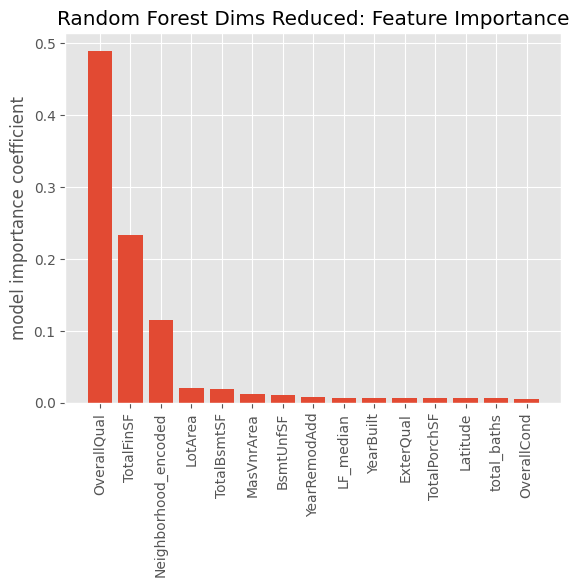

In [17]:
# Extract feature importance from best xgb model
rf_feature_importances = rf_final_model.named_steps['regressor'].feature_importances_

# Get feature names after one-hot encoding
# one_hot_encoded_features = best_rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Add the name for the target encoded 'Neighborhood' column
# Assuming 'Neighborhood_encoded' or similar as the name
target_encoded_feature = ['MSSubClass_encoded', 'MSZoning_encoded', 'Neighborhood_encoded', 'Condition1_encoded', 'Condition2_encoded',
'HouseStyle_encoded', 'RoofStyle_encoded', 'Exterior1st_encoded', 'Electrical_encoded', 'ClassPr_S_encoded']

# Get numeric feature names
numeric_features = X.select_dtypes(exclude=['object']).columns

# Combine all feature names
all_features = np.concatenate([target_encoded_feature, numeric_features])

# Map feature importance to feature names
feature_importance_dict = dict(zip(all_features, rf_feature_importances))

# Sort by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

rf_feature_importance = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'], index=None)

# Plot Feature Importance - top 15
import matplotlib.pyplot as plt

rf_importance_15 = rf_feature_importance.head(15)
plt.bar(rf_importance_15['Feature'], rf_importance_15['Importance'])
plt.xticks(rotation=90)
plt.ylabel('model importance coefficient')
plt.title("Random Forest Dims Reduced: Feature Importance")
plt.show()


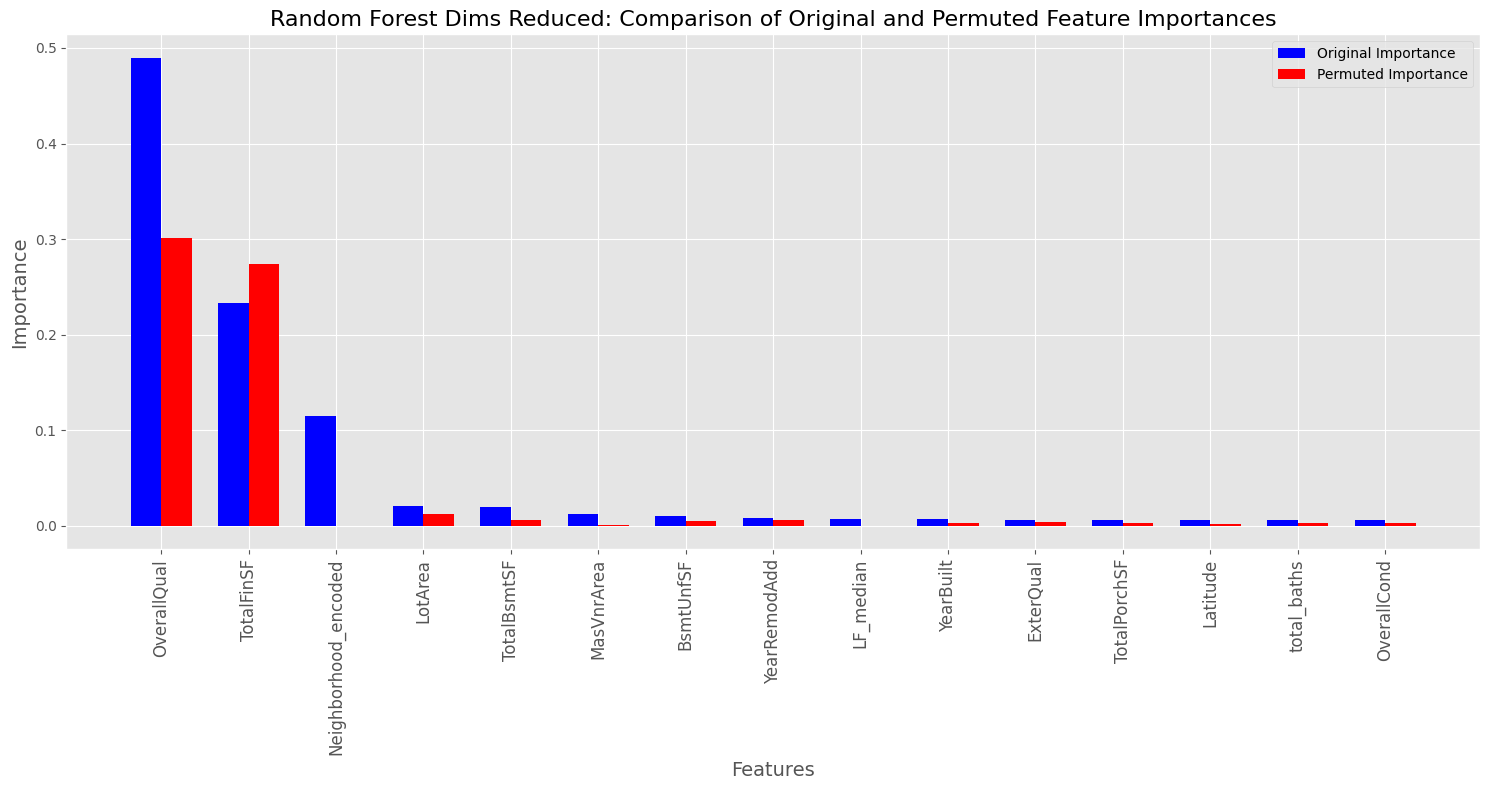

In [18]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
import joblib

def permuted_feature_importance(pipeline, X_test, y_test):
    baseline_r2 = r2_score(y_test, pipeline.predict(X_test))
    importances = {}

    for feature in X_test.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])

        permuted_r2 = r2_score(y_test, pipeline.predict(X_test_permuted))
        importances[feature] = baseline_r2 - permuted_r2

    return importances

# Calculate permuted feature importance
rf_permuted_importances = permuted_feature_importance(rf_final_model, X_test, y_test)

# Convert to DataFrame and sort
rf_permuted_importances_df = pd.DataFrame.from_dict(rf_permuted_importances, orient='index', columns=['Importance'])
rf_permuted_importances_df.sort_values(by='Importance', ascending=False, inplace=True)


# Select the top 15 features from the original importances for comparison
top_features = rf_feature_importance.head(15)['Feature']

# Initialize an empty DataFrame to store the comparison
comparison_importances = pd.DataFrame(index=top_features)

# Retrieve the original importances for the top features
comparison_importances['Original Importance'] = rf_feature_importance.set_index('Feature').reindex(top_features)['Importance']

# Retrieve the permuted importances for the same top features
# Make sure to match the feature names exactly
comparison_importances['Permuted Importance'] = rf_permuted_importances_df.reindex(top_features)['Importance']

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.35
index = np.arange(len(top_features))

# Plotting both bars
ax.bar(index, comparison_importances['Original Importance'], bar_width, label='Original Importance', color='b')
ax.bar(index + bar_width, comparison_importances['Permuted Importance'], bar_width, label='Permuted Importance', color='r')

# Adding labels, legend, and title
ax.set_xlabel('Features', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)
ax.set_title('Random Forest Dims Reduced: Comparison of Original and Permuted Feature Importances', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(comparison_importances.index, rotation=90, fontsize=12)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
100%|===================| 1783/1789 [01:40<00:00]        

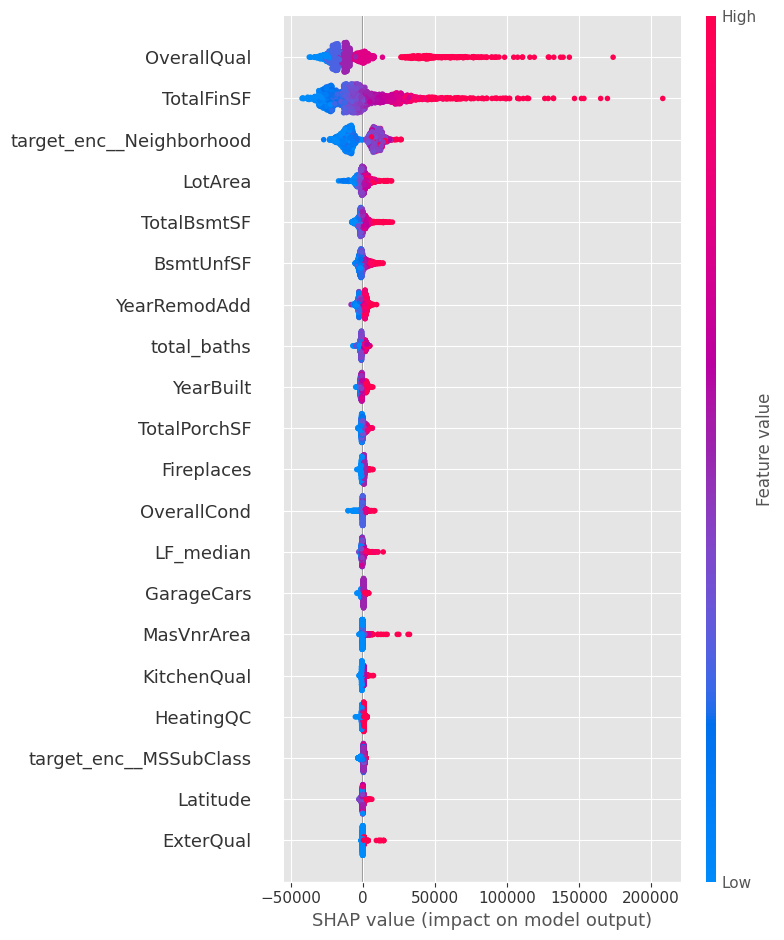

In [19]:
import shap
import scipy.sparse 
# Get RF SHAP values
rf_model = rf_final_model.named_steps['regressor']

# Preprocess using model preprocessor
X_train_preprocessed = rf_final_model.named_steps['preprocessor'].transform(X_train)

# Convert one-hot encoded data to dense format
if isinstance(X_train_preprocessed, scipy.sparse.csr.csr_matrix):
    X_train_preprocessed = X_train_preprocessed.toarray()


# encoded_features = best_rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Add the target encoded 'Neighborhood' feature name
target_encoded_feature = ['target_enc__MSSubClass', 'target_enc__MSZoning', 'target_enc__Neighborhood', 'target_enc__Condition1', 
                          'target_enc__Condition2','target_enc__HouseStyle', 'target_enc__RoofStyle', 'target_enc__Exterior1st', 
                          'target_enc__Electrical', 'target_enc__ClassPr_S']

# Get numeric feature names
numeric_features = X.select_dtypes(exclude=['object']).columns

# Combine all feature names
preprocessed_feature_names = np.concatenate([target_encoded_feature, numeric_features])

# Create SHAP explainer
explainer = shap.Explainer(rf_model, X_train_preprocessed)

shap_values = explainer(X_train_preprocessed)

shap.summary_plot(shap_values, X_train_preprocessed, feature_names=preprocessed_feature_names)


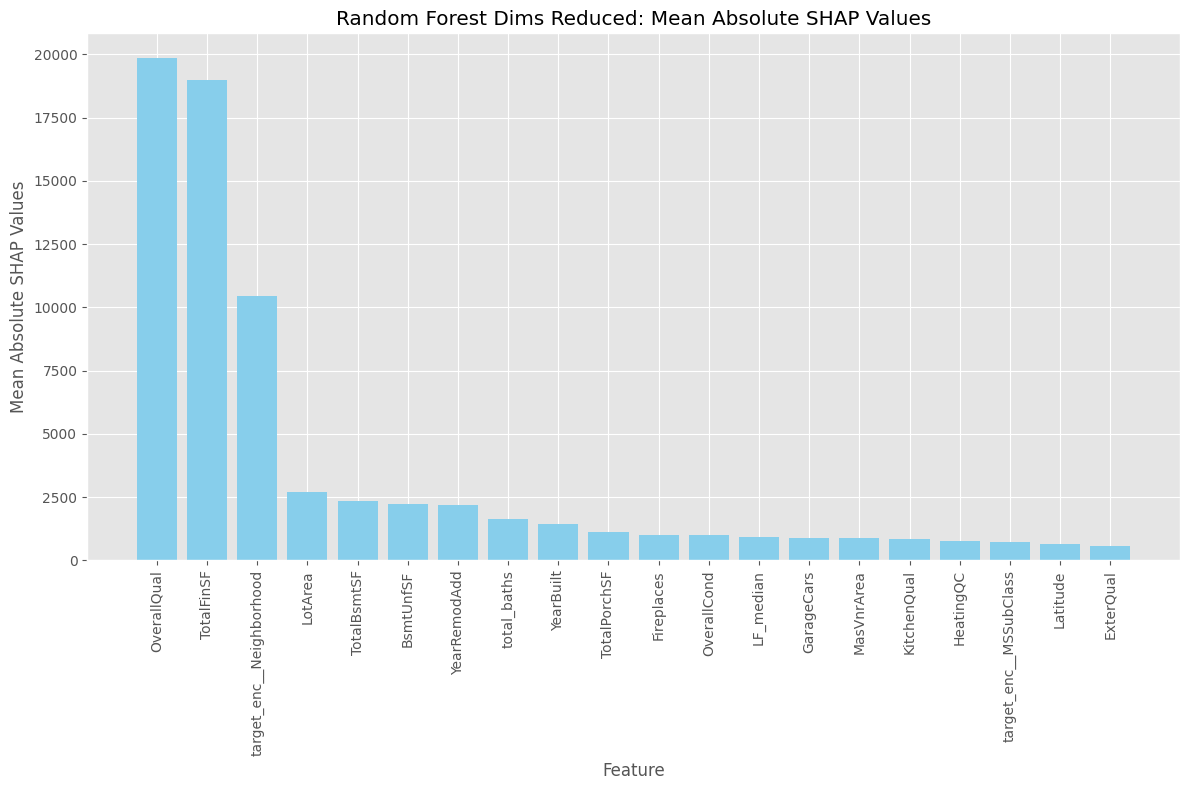

In [20]:
# Plot mean absolute shap values 
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

feature_names = preprocessed_feature_names

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
})

top_features = feature_importance.sort_values(by='mean_abs_shap', ascending=False).head(20)

plt.style.use("ggplot")
# Plot
plt.figure(figsize=(12,8))
plt.bar(top_features['feature'], top_features['mean_abs_shap'], color='skyblue')
plt.ylabel('Mean Absolute SHAP Values')
plt.xlabel('Feature')
plt.title('Random Forest Dims Reduced: Mean Absolute SHAP Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


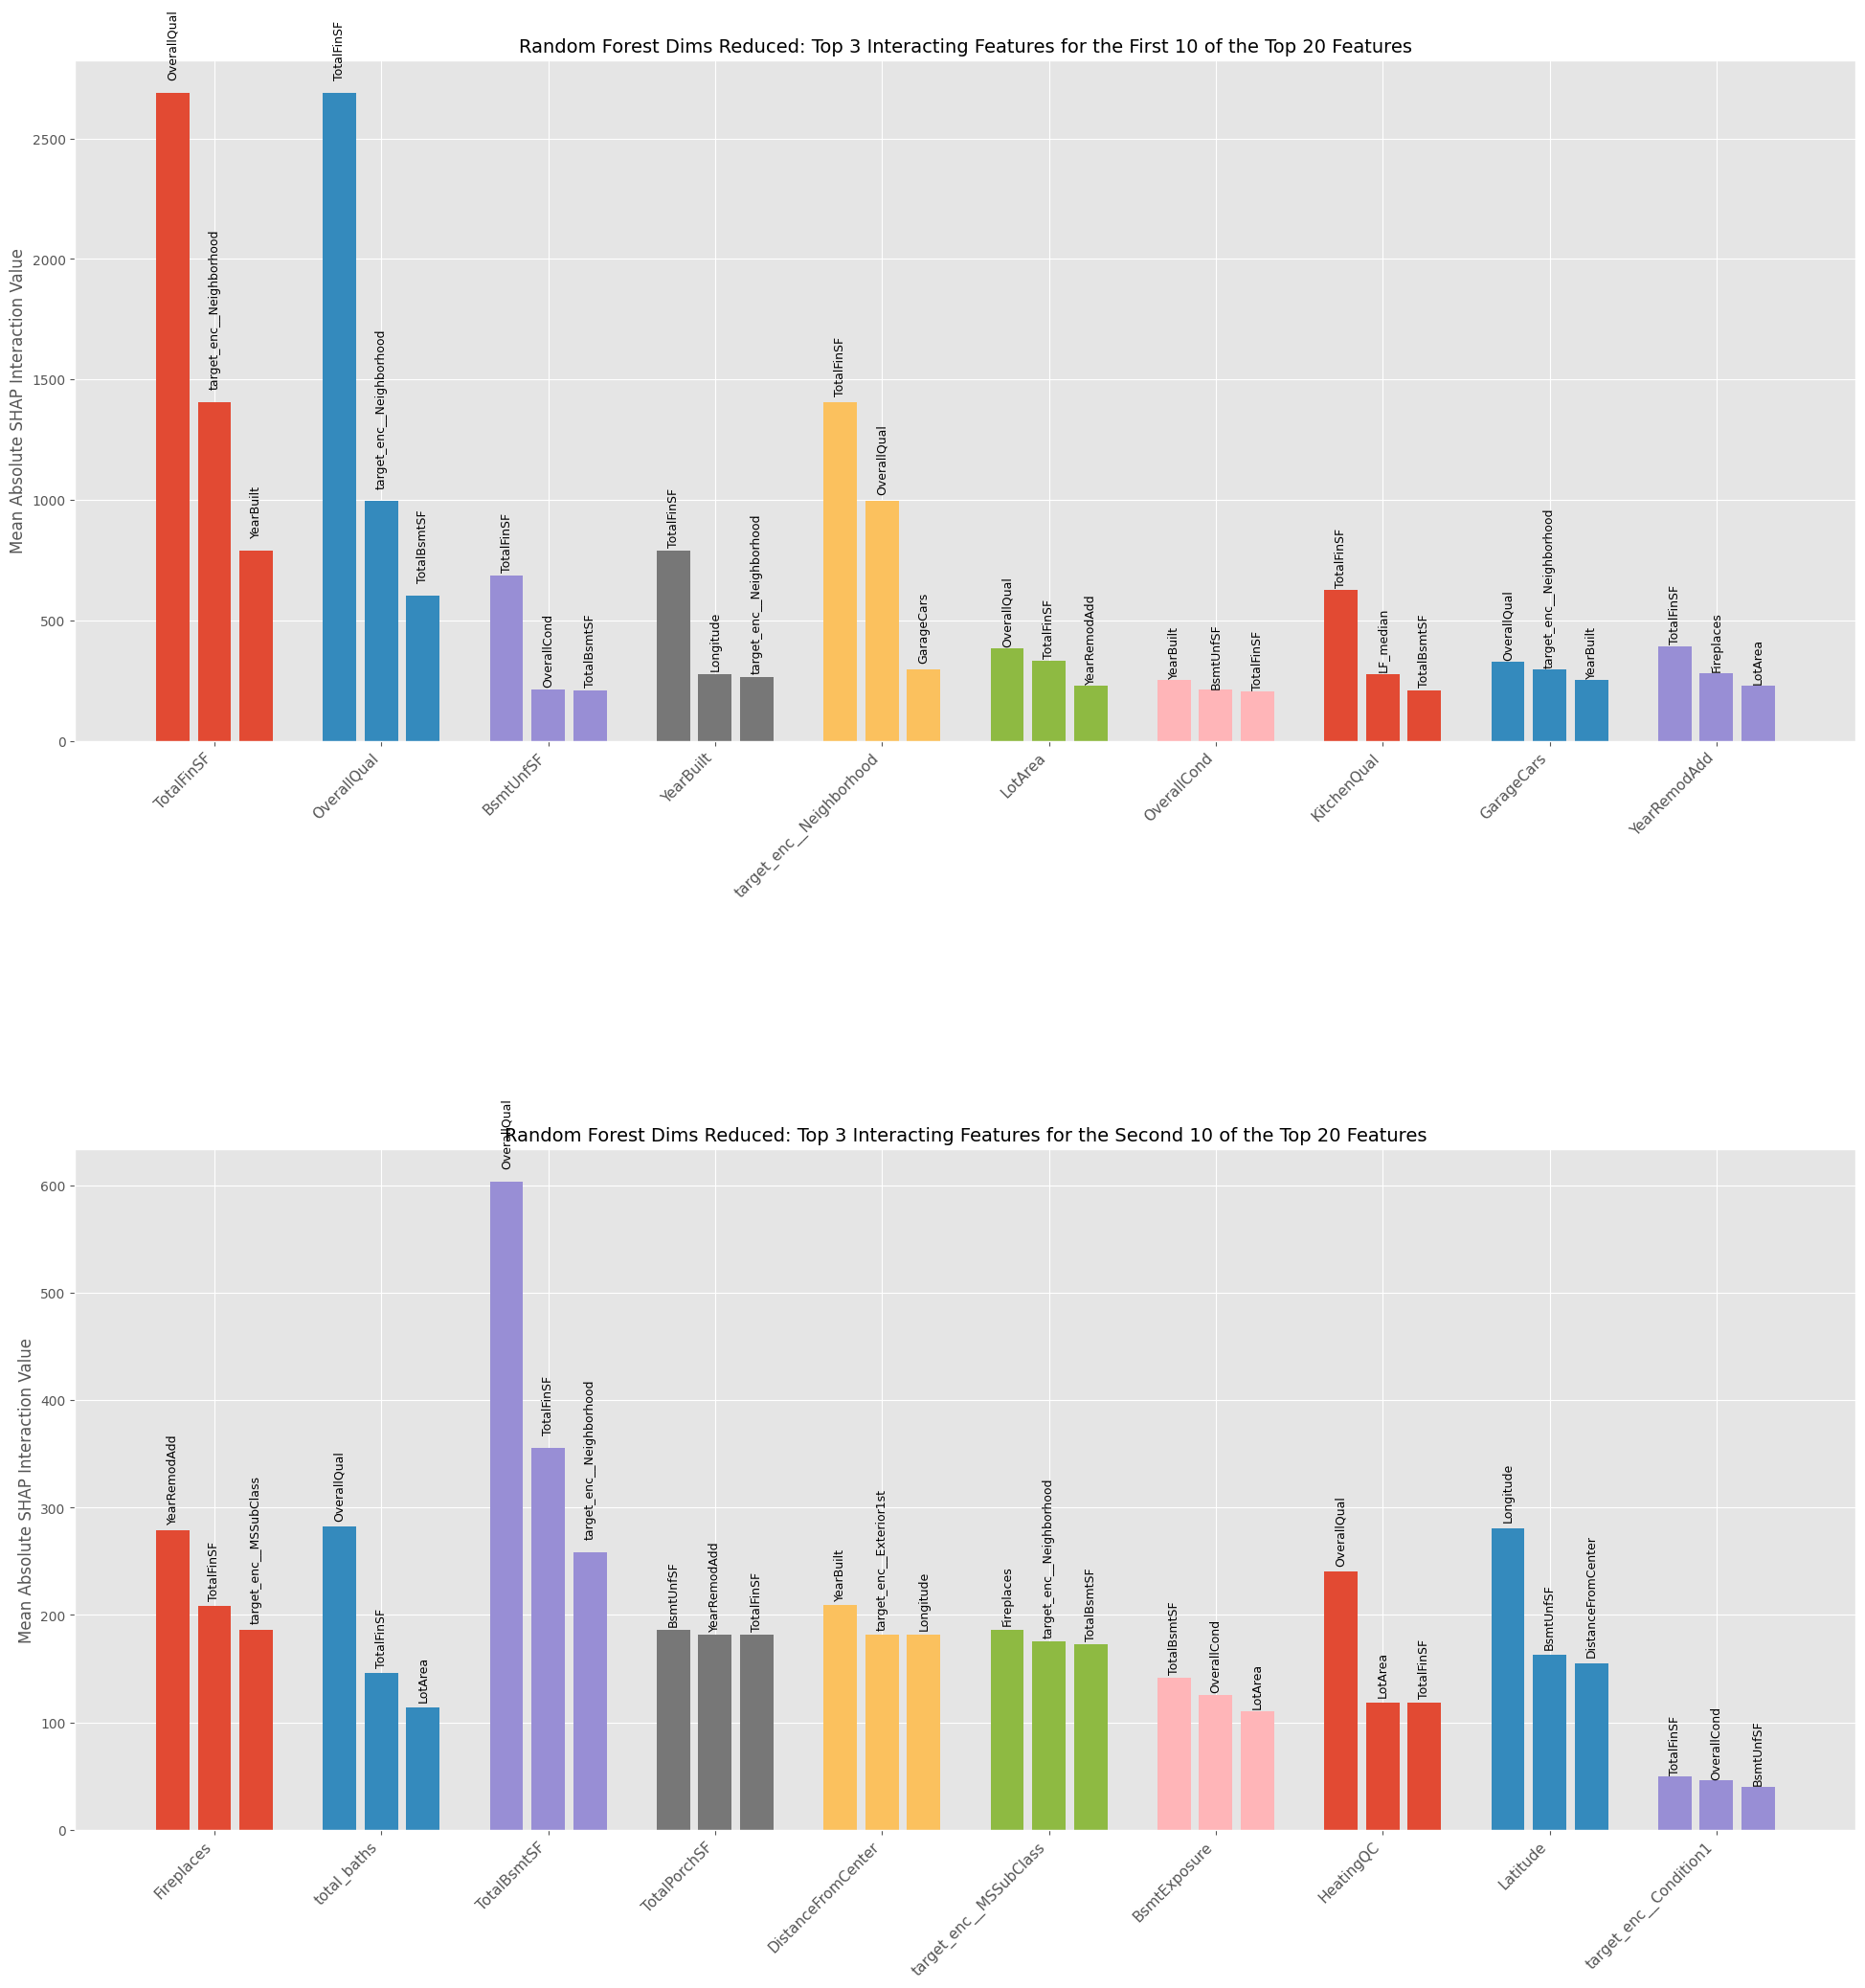

In [22]:
import concurrent.futures
import numpy as np
import matplotlib.pyplot as plt
import shap
# import cProfile, pstats  # Uncomment if profiling

# Assuming rf_final_model and other required variables are already defined

def main():
    # Create SHAP explainer 
    rf_model = rf_final_model.named_steps['regressor']
    explainer = shap.Explainer(rf_model, feature_names=preprocessed_feature_names)

    # Calc interaction values
    interaction_values = explainer.shap_interaction_values(X_train_preprocessed)

    # Calc mean interaction values across all samples
    mean_interaction_values = np.abs(interaction_values).mean(axis=0)

    top_20_feature_names = top_features['feature'].head(20)

    # Function to get top interactions for a single feature
    def get_top_interactions(feature):
        feature_idx = np.where(preprocessed_feature_names == feature)[0][0]
        feature_interactions = mean_interaction_values[feature_idx, :]
        top_3_idx = np.argsort(feature_interactions)[-4:-1]  # Exclude last one: the feature itself
        top_3_features = preprocessed_feature_names[top_3_idx]
        top_3_values = feature_interactions[top_3_idx]
        return feature, top_3_features, top_3_values

    # Use ThreadPoolExecutor to parallelize the computation
    top_interactions = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(get_top_interactions, feature) for feature in top_20_feature_names]
        for future in concurrent.futures.as_completed(futures):
            try:
                feature, features, values = future.result()
                top_interactions[feature] = (features, values)
            except Exception as e:
                print(f"Error processing feature: {e}")

    # Create func for plotting
def plot_feature_interactions(interactions_dict, features, ax):
    for i, feature in enumerate(features):
        # Get the top 3 interactions for the feature
        interacting_features, values = interactions_dict[feature]
        sorted_idx = np.argsort(values)[::-1]  # Sort the values in descending order
        values = values[sorted_idx]
        interacting_features = interacting_features[sorted_idx]

        # Position of bars for this feature
        bar_positions = np.array(range(i*4, i*4 + 3))
        
        # Plot the bars
        ax.bar(bar_positions, values)

        # Annotate bars with feature names
        for pos, val, interact_feature in zip(bar_positions, values, interacting_features):
            ax.text(pos, val + 0.02 * max(values), interact_feature, ha='center', va='bottom', rotation=90, fontsize=9)

    # Set the x-ticks to be in the middle of each group of bars
    ax.set_xticks([i*4 + 1 for i in range(len(features))])
    ax.set_xticklabels(features, rotation=45, ha='right', fontsize=11)
    ax.set_ylabel('Mean Absolute SHAP Interaction Value', fontsize=12)

# Split the top 20 features into two groups of 10
first_10_features = list(top_20_feature_names)[:10]
second_10_features = list(top_20_feature_names)[10:]

# Create subplots 
fig, axs = plt.subplots(2, 1, figsize=(24, 24), gridspec_kw={'hspace': 0.6})  # Adjust horizontal spacing

# Plot interactions for the first 10 features
plot_feature_interactions(top_interactions, first_10_features, axs[0])
axs[0].set_title('Random Forest Dims Reduced: Top 3 Interacting Features for the First 10 of the Top 20 Features', fontsize=14)

# Plot interactions for the second 10 features
plot_feature_interactions(top_interactions, second_10_features, axs[1])
axs[1].set_title('Random Forest Dims Reduced: Top 3 Interacting Features for the Second 10 of the Top 20 Features', fontsize=14)

# Show the plot with adjusted layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


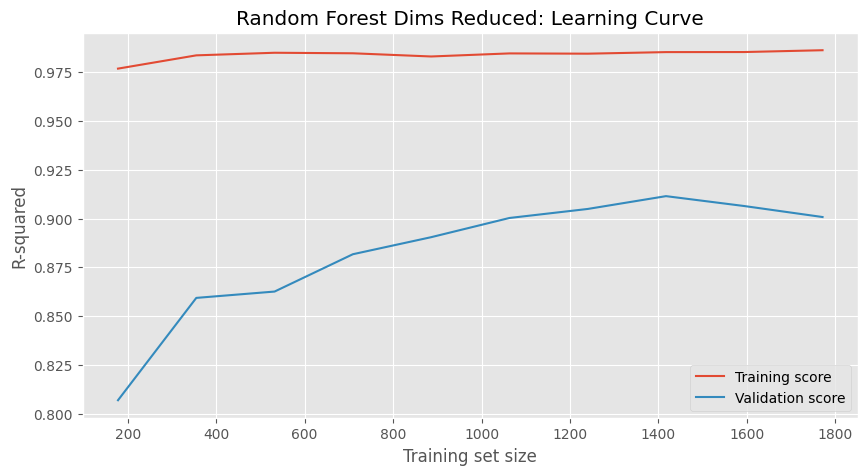

In [23]:
# Learning Curve - see how model improves with more data - also get SHAP as I train

from sklearn.metrics import mean_squared_error, r2_score

def compute_shap_values(pipeline, X_train, y_train, X_val):
    pipeline.fit(X_train, y_train)
    model = pipeline.named_steps['regressor']
   
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_transformed)

    # Compute mean SHAP values
    mean_shap_values = np.mean(shap_values, axis=0)
    
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    return pd.DataFrame({'feature': transformed_feature_names, 'mean_shap_value': mean_shap_values})

# Lists to store results
train_sizes = []
train_scores = []
validation_scores = []
shap_values_dfs = []

# Define range of training set sizes 
for frac in np.linspace(0.1, 0.99, 10):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    # Calc SHAP vals per subset
    shap_df = compute_shap_values(rf_final_model, X_train_sub, y_train_sub, X_val_sub)    
    shap_values_dfs.append(shap_df)
    
    # Store training set size
    train_sizes.append(X_train_sub.shape[0])

    # Evaluate model by set size
    train_predictions = rf_final_model.predict(X_train_sub)
    train_score = r2_score(y_train_sub, train_predictions)
    train_scores.append(train_score)

    # Evaluate on validation set
    val_predictions = rf_final_model.predict(X_val_sub)
    val_score = r2_score(y_val_sub, val_predictions)
    validation_scores.append(val_score)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_scores, label='Training score')
plt.plot(train_sizes, validation_scores, label='Validation score')
plt.ylabel('R-squared')
plt.xlabel('Training set size')
plt.title('Random Forest Dims Reduced: Learning Curve')
plt.legend()
plt.show()
    

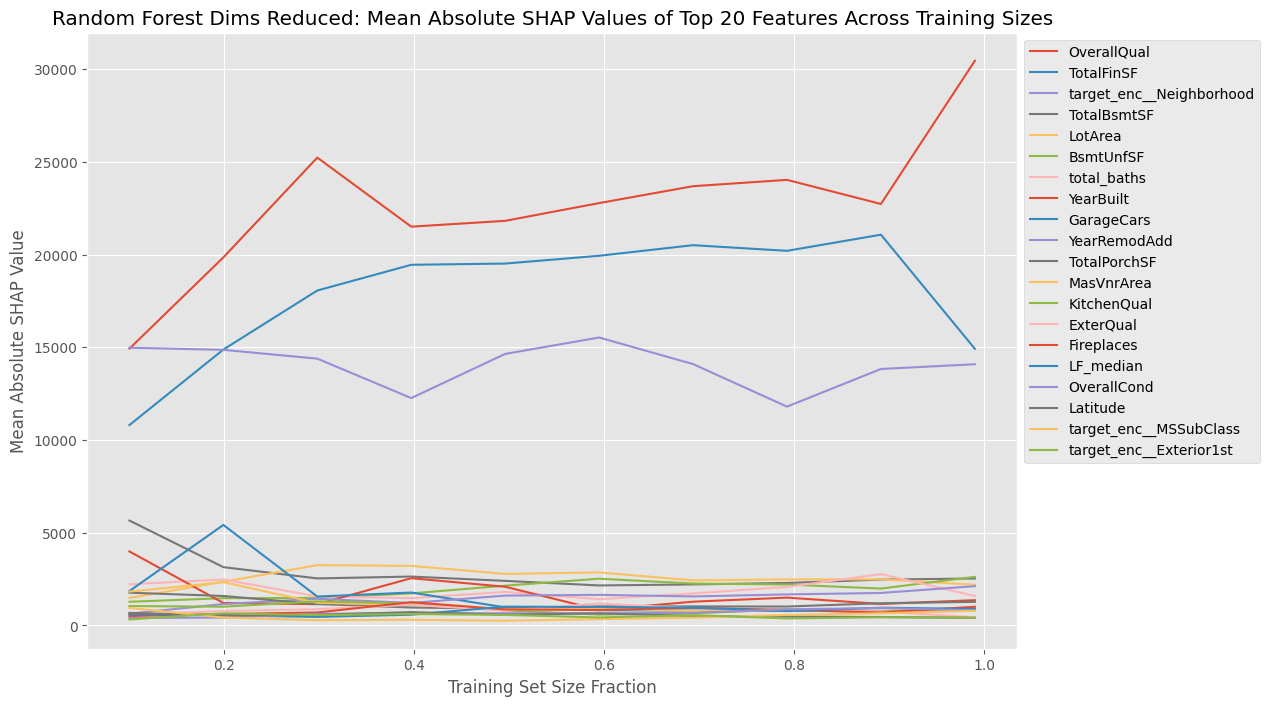

In [24]:
# Now plot the changes in SHAP values per training set size

# Function to calc abs SHAP values and pair with feature names
def compute_absolute_shap_values(pipeline, X_train, y_train, X_val):
    pipeline.fit(X_train, y_train)
    model = pipeline.named_steps['regressor']
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_transformed)

    abs_shap_values = np.abs(shap_values)
    
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    return pd.DataFrame(abs_shap_values, columns=transformed_feature_names)

# Lists to store results
train_sizes = []
shap_values_aggregated = pd.DataFrame()

# Compute mean abs SHAP vals per training set size model
for frac in np.linspace(0.1, 0.99, 10):
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train, y_train, train_size=frac, random_state=42)

    abs_shap_df = compute_absolute_shap_values(rf_final_model, X_train_sub, y_train_sub, X_val_sub)
    shap_values_aggregated[frac] = abs_shap_df.mean()

    train_sizes.append(X_train_sub.shape[0])

# Convert fractions to consistent format (e.g., string) for df column names
train_sizes_str = [str(size) for size in train_sizes]

# Get top 20 features
top_features = shap_values_aggregated.mean(axis=1).nlargest(20).index

# Remove prefix from feature names
top_features_cleaned = top_features.str.replace('^cat__|^remainder__', '', regex=True)

# Initialize df 
top_features_shap_values = pd.DataFrame(index=top_features_cleaned)

# Populate df with mean abs SHAP values for top features across all training sizes
for size in shap_values_aggregated.columns:
    for feature, cleaned_feature in zip(top_features, top_features_cleaned):
        top_features_shap_values.at[cleaned_feature, size] = shap_values_aggregated.at[feature, size]

# Plot
plt.figure(figsize=(12, 8))
for feature in top_features_shap_values.index:
    plt.plot(shap_values_aggregated.columns, top_features_shap_values.loc[feature, :], label=feature)

plt.xlabel('Training Set Size Fraction')
plt.ylabel('Mean Absolute SHAP Value')
plt.title('Random Forest Dims Reduced: Mean Absolute SHAP Values of Top 20 Features Across Training Sizes')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed: 4

                          Mean Abs SHAP Value  Std Dev SHAP Value  \
OverallQual                      26646.431775         2043.894609   
TotalFinSF                       18865.779656         1409.891133   
target_enc__Neighborhood         13278.107456         2725.489284   
LotArea                           2719.330518          492.181243   
TotalBsmtSF                       2329.611130          576.992652   
BsmtUnfSF                         1899.264852          329.270407   
YearRemodAdd                      1729.044329          356.784241   
total_baths                       1600.005500         1074.897753   
YearBuilt                         1394.874918          570.453300   
TotalPorchSF                      1126.270773          251.668257   

                                  2.5%         97.5%  
OverallQual               22996.616592  31485.943806  
TotalFinSF                16452.629572  21970.315094  
target_enc__Neighborhood   7740.342519  17265.606426  
LotArea             

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 99.6min finished


<Figure size 1200x700 with 0 Axes>

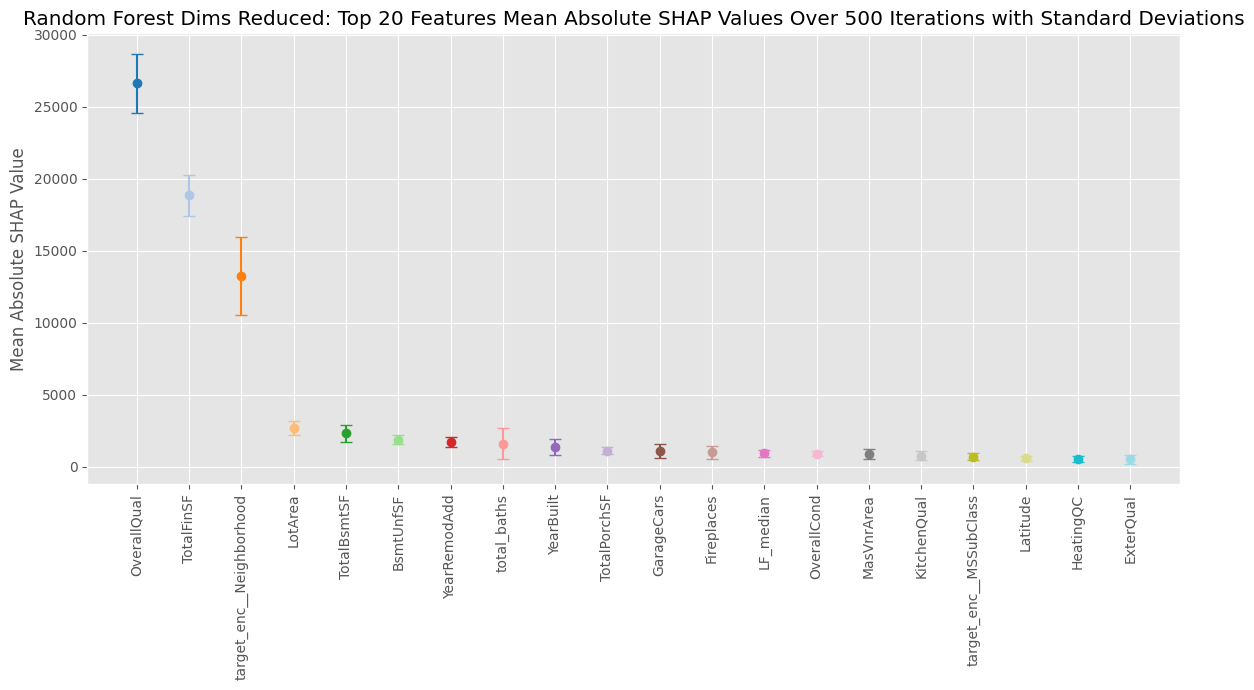

In [27]:
# Calc mean abs shap values per feature over 500 boostrapping iterations and see avgs and st devs for variability

from joblib import Parallel, delayed
from sklearn.utils import resample

# Use the pipeline that includes the RF regressor and preprocessing
rf_pipeline = rf_final_model

# Define a function to compute SHAP values on bootstrap samples
def compute_bootstrap_shap_values(X, y, pipeline, n):
    import shap
    from sklearn.utils import resample

    # Resample the data
    X_sample, y_sample = resample(X, y, replace=True)
    
    # Train the pipeline on the resampled data
    pipeline.fit(X_sample, y_sample)
    
    # Extract the trained model from the pipeline
    trained_model = pipeline.named_steps['regressor']
    
    # Get the preprocessed features from the pipeline
    X_sample_transformed = pipeline.named_steps['preprocessor'].transform(X_sample)

    print(f"Computing SHAP values for bootstrap sample ...")

    # Create SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(trained_model)
    shap_values = explainer.shap_values(X_sample_transformed)

    # Calculate the mean absolute SHAP values
    mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
    
    # Retrieve feature names
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Return the mean SHAP values along with feature names
    return pd.Series(mean_abs_shap_values, index=feature_names)

# Number of bootstrapping iterations
n_iterations = 500
n_jobs = -1  # Use all available cores

# Perform the bootstrap calculations
bootstrap_results = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(compute_bootstrap_shap_values)(X_train, y_train, rf_final_model, len(y_train)) for i in range(n_iterations)
)

# Convert the results to a DataFrame
bootstrap_shap_values = pd.DataFrame(bootstrap_results)

# Calculate the mean and standard deviation of the SHAP values
mean_abs_shap_values = bootstrap_shap_values.mean(axis=0)
std_shap_values = bootstrap_shap_values.std(axis=0)

# Calculate the confidence intervals
conf_intervals = bootstrap_shap_values.quantile([0.025, 0.975], axis=0).T
conf_intervals.columns = ['2.5%', '97.5%']

# Combine mean, std, and confidence intervals into one DataFrame
rf_shap_stats = pd.DataFrame({
    'Mean Abs SHAP Value': mean_abs_shap_values, 
    'Std Dev SHAP Value': std_shap_values
}).join(conf_intervals)


# Sort the features by the absolute mean SHAP value
rf_shap_stats = rf_shap_stats.reindex(mean_abs_shap_values.abs().sort_values(ascending=False).index)
rf_shap_stats.index = rf_shap_stats.index.str.replace('remainder__', '')

# Print the top 10 features for inspection
print(rf_shap_stats.head(10))

# Now you can use mean_shap_values and conf_intervals as needed for further analysis or plotting
top_20_features = rf_shap_stats['Mean Abs SHAP Value'].abs().sort_values(ascending=False).head(20).index

# Plot mean of top ten most impactful features with std dev
plt.figure(figsize=(12, 7))

top_20_features = rf_shap_stats.head(20)

# Generate a list of colors
colors = plt.cm.tab20(np.linspace(0, 1, 20))

plt.figure(figsize=(12, 7))

# Plot each feature with a unique color
for i, (feature_name, row) in enumerate(top_20_features.iterrows()):
    plt.errorbar(i, row['Mean Abs SHAP Value'], yerr=row['Std Dev SHAP Value'], fmt='o', capsize=4, color=colors[i], label=feature_name)

plt.xticks(range(len(top_20_features)), top_20_features.index, rotation=90)
plt.ylabel('Mean Absolute SHAP Value')
plt.title('Random Forest Dims Reduced: Top 20 Features Mean Absolute SHAP Values Over 500 Iterations with Standard Deviations')

# Create a custom legend
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [30]:
preprocessed_feature_names

array(['target_enc__MSSubClass', 'target_enc__MSZoning',
       'target_enc__Neighborhood', 'target_enc__Condition1',
       'target_enc__Condition2', 'target_enc__HouseStyle',
       'target_enc__RoofStyle', 'target_enc__Exterior1st',
       'target_enc__Electrical', 'target_enc__ClassPr_S', 'LotArea',
       'LotShape', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       'LowQualFinSF', 'BedroomAbvGr', 'KitchenQual', 'Functional',
       'Fireplaces', 'GarageFinish', 'GarageCars', 'PavedDrive', 'MoSold',
       'SaleCondition', 'Latitude', 'Longitude', 'LF_median',
       'DistanceFromCenter', 'total_baths', 'TotalPorchSF', 'TotalFinSF'],
      dtype=object)

[19:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[19:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


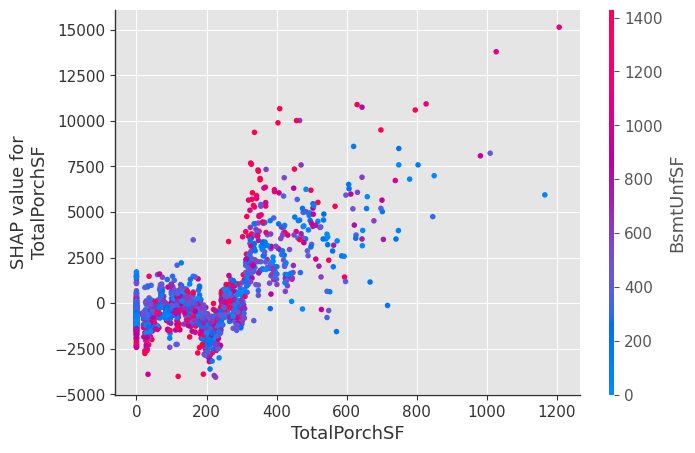

In [47]:
# Plot highly interactive pairs of features as dependence plot
import matplotlib.pyplot as plt

# Define feature name
feature_name = 'TotalPorchSF'

# Create SHAP explainer for the model
explainer = shap.Explainer(xgb_model, X_train_preprocessed)

# Calc SHAP values for the feature
shap_values = explainer.shap_values(X_train_preprocessed)

# Generate a dependence plot for feature (and interaction feature)
shap.dependence_plot(feature_name, shap_values, X_train_preprocessed, feature_names=preprocessed_feature_names, interaction_index= 'BsmtUnfSF')


<Axes: xlabel='OverallQual', ylabel='TotalFinSF'>

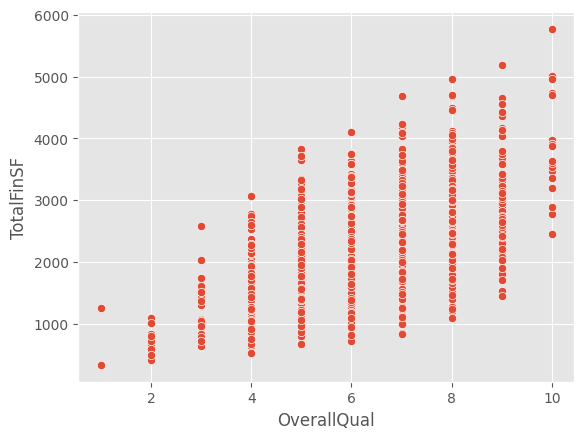

In [34]:
import seaborn as sns
sns.scatterplot(data=ames_dimreduced, x='OverallQual', y='TotalFinSF')

<Axes: xlabel='TotalFinSF', ylabel='SalePrice'>

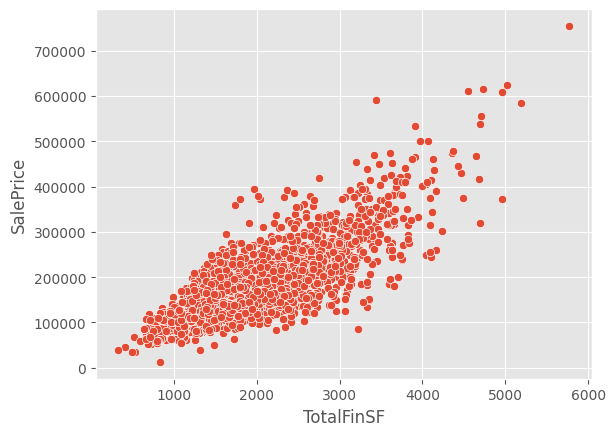

In [35]:
sns.scatterplot(data=ames_dimreduced, x='TotalFinSF', y='SalePrice')

[16:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


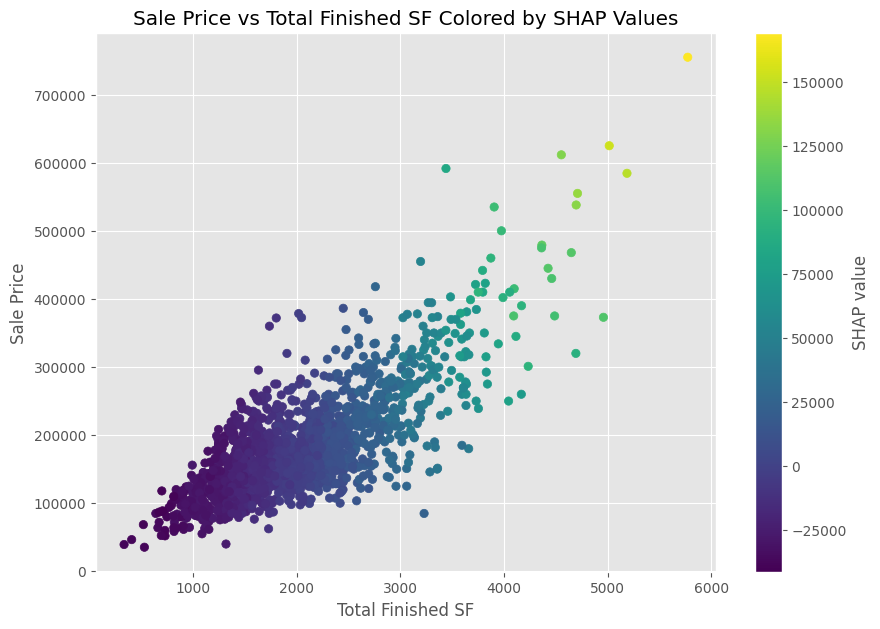

In [42]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# Create SHAP explainer for the model
explainer = shap.Explainer(xgb_model, X_train_preprocessed)

# Calc SHAP values for X_train_preprocessed
shap_values = explainer.shap_values(X_train_preprocessed)

# Find the index of 'TotalFinSF' in preprocessed_feature_names
totalfinsf_index = np.where(preprocessed_feature_names == 'TotalFinSF')[0][0]

# Extract the SHAP values for the feature 'TotalFinSF'
totalfinsf_shap_values = shap_values[:, totalfinsf_index]

# Make sure you have y_train which corresponds to SalePrice values for the training set
# Also, ensure totalfinsf_index is the correct index for TotalFinSF in X_train_preprocessed

plt.figure(figsize=(10, 7))
plt.scatter(X_train_preprocessed[:, totalfinsf_index], y_train, c=totalfinsf_shap_values, cmap='viridis')

# Set the color bar to the right of the plot
cbar = plt.colorbar()
cbar.set_label('SHAP value')

# Label the axes
plt.xlabel('Total Finished SF')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Total Finished SF Colored by SHAP Values')

# Show the plot
plt.show()


